# Modelamiento geo-espacial y temporal del robo en el área metropolitana de Barranquilla.

En este archivo, se realizará el Data QA para los archivos extraídos de la base de datos de la polícia nacional (SIEDCO), y luego se realizará un análisis exploratorio y feature engineering de los datos.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import datetime as dt
import random

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

%load_ext lab_black

## Carga de datos y descripción

Los datos descargados de la base de datos de la poliíca nacional vienen en formato csv por año. Los últimos dos años vienen en dos archivos. Estos archivos cuentan con toda la información que tiene la policía nacional sobre los robos reportados en todo el país desde 2010 hasta 2019. Cada fila del archivo es un incidente reportado. Las columnas que tienen los archivos descargados son: 

- Fecha: Indica la fecha del incidente, y está en formato DD/MM/YYYY.
- Departamento: Indica el departamento donde sucedió el incidente.
- Municipio: Indica el municipio donde sucedió el incidente.
- Día: Día de la semana donde sucedió el incidente.
- Hora: Hora del incidente, en formato HH:MM:SS.	
- Barrio: Barrio del municipio donde sucedió el incidente.	
- Zona: Zona clasificada como Urbana o Rural.	
- Clase de sitio: Clase de lugar donde ocurrió el incidente, i.e. Vías Públicas, Local Comercial, etc. 	
- Arma empleada: Arma empleada por el agresor para cometer el incidente.
- Móvil Agresor: Medio de transporte del agresor.
- Móvil Victima: Medio de transporte de la víctima.	
- Edad: Edad de la víctima.	
- Sexo: Sexo reportado de la víctima.	
- Estado cívil: Estado cívil de la víctima.	
- País de nacimiento: País de nacimiento de la víctima.	
- Clase de empleado: Tipo de empleo de la víctima (Empleado particular, independiente, etc.)
- Profesión: Profesión de la víctima.	
- Escolaridad: Nivel de escolaridad de la víctima.	
- Código DANE: Código DANE del municipio donde ocurrió el incidente.	
- Cantidad: Cantidad de robos reportada en el incidente.

Adicionalmente, tenemos dos archivos, uno con información de los GEOID de cada barrio, y otra, con una agregación de los sitios, ya que esa columna tiene muchas opciones. Miremos uno de los archivos de la base de la polícia nacional.

In [3]:
# Cargando uno de los archivos
df_dummy = pd.read_csv(
    "./DS4A-data-source-master/csvs/hurto-personas-2010.csv.gz",
    sep="\t",
    header=0,
    na_values=np.nan,
)
df_dummy.head()

,Fecha,Departamento,Municipio,Día,Hora,Barrio,Zona,Clase de sitio,Arma empleada,Móvil Agresor,Móvil Victima,Edad,Sexo,Estado civil,País de nacimiento,Clase de empleado,Profesión,Escolaridad,Código DANE,Cantidad
0,01/01/2010,ANTIOQUIA,APARTADÓ,Viernes,17:00:00,EL SALVADOR,URBANA,VIAS PUBLICAS,NO REPORTADO,A PIE,A PIE,21,FEMENINO,NO REPORTA,COLOMBIA,EMPLEADO PARTICULAR,-,SECUNDARIA,5045000,1
1,01/01/2010,ANTIOQUIA,LA ESTRELLA,Viernes,09:59:59,ZONA CENTRO,URBANA,NO DEFINIDO,SIN EMPLEO DE ARMAS,A PIE,A PIE,23,MASCULINO,CASADO,COLOMBIA,EMPLEADO PUBLICO,-,TECNICO,5380000,1
2,01/01/2010,ANTIOQUIA,MEDELLÍN (CT),Viernes,15:00:00,EL POBLADO C-14,URBANA,ALMACENES,SIN EMPLEO DE ARMAS,A PIE,A PIE,52,MASCULINO,CASADO,COLOMBIA,EMPLEADO PARTICULAR,TECNOLOGO,SUPERIOR,5001000,1
3,01/01/2010,ANTIOQUIA,MEDELLÍN (CT),Viernes,00:00:00,EL POBLADO C-14,URBANA,APARTAMENTO EN CONJUNTO CERRADO,SIN EMPLEO DE ARMAS,A PIE,A PIE,53,MASCULINO,CASADO,COLOMBIA,EMPLEADO PARTICULAR,ECONOMIA,SUPERIOR,5001000,1
4,01/01/2010,ANTIOQUIA,MEDELLÍN (CT),Viernes,18:30:00,CASTROPOL C-14,URBANA,FRENTE RESTAURANTE,ARMA DE FUEGO,CONDUCTOR MOTOCICLETA,CONDUCTOR VEHICULO,28,MASCULINO,SOLTERO,COLOMBIA,INDEPENDIENTE,-,SECUNDARIA,5001000,1


Ahora, vamos a unir todos los archivos en un sólo dataframe, y vamos a filtrar la zona que nos interesa, que es Barranquilla y Soledad:

In [4]:
# List all files in folder with gz extension
extension = "DS4A-data-source-master/csvs/*.gz"
all_files = glob.glob(extension)

# Read and concatenate dataframes
df = pd.concat(
    [pd.read_csv(f, sep="\t", header=0, na_values="-") for f in all_files],
    ignore_index=True,
)

In [5]:
df.shape

(1412808, 20)

In [6]:
# Filter data from Atlántico and Barranquilla and Soledad
df = df[
    (df["Departamento"] == "ATLÁNTICO")
    & ((df["Municipio"] == "BARRANQUILLA (CT)") | (df["Municipio"] == "SOLEDAD"))
].reset_index(drop=True)
df.shape

(68966, 20)

Tenemos entonces después de unir todos los archivos y filtrar por Barranquilla y Soledad, tenemos 68966 registros de robos efectuados entre 2010 y 2019. Realicemos un pequeño Data QA de los datos cómo están en este momento.

In [7]:
# Revisando la proporción de datos faltantes en la tabla
porcentaje_nans = (df.isna().sum() / df.shape[0]) * 100
porcentaje_nans

Fecha                  0.000000
Departamento           0.000000
Municipio              0.000000
Día                    0.000000
Hora                   0.000000
Barrio                 0.269698
Zona                   0.000000
Clase de sitio         0.040600
Arma empleada          0.313198
Móvil Agresor          2.785431
Móvil Victima          1.158542
Edad                   1.130992
Sexo                   0.042050
Estado civil           1.128092
País de nacimiento     0.591596
Clase de empleado      0.042050
Profesión             57.019401
Escolaridad            1.128092
Código DANE            0.000000
Cantidad               0.000000
dtype: float64

Se puede observar que el porcentaje de valor faltante de las columnas es menor, con un 2.78% o menos de datos faltantes. La excepción a esto es la columna de Profesión, la cuál tiene 57% de datos faltantes. Esta columna se borrará ya que la proporción de datos faltantes es muy alta. Para las otras columnas se revisará cada caso específico, pero dependiendo si las columnas serán relevantes más adelante para nuestro modelo o no.

In [8]:
df["Departamento"].value_counts()

ATLÁNTICO    68966
Name: Departamento, dtype: int64

In [9]:
df["Municipio"].value_counts()

BARRANQUILLA (CT)    59066
SOLEDAD               9900
Name: Municipio, dtype: int64

In [10]:
df["Día"].value_counts()

Viernes      11175
Sábado       10810
Jueves       10438
Miércoles    10349
Martes       10090
Lunes         9131
Domingo       6973
Name: Día, dtype: int64

In [11]:
df["Hora"].value_counts()

00:00:00    3717
10:00:00    1616
11:00:00    1431
10:30:00    1395
08:00:00    1293
            ... 
16:41:00       1
05:36:00       1
04:17:00       1
08:29:00       1
21:21:00       1
Name: Hora, Length: 1401, dtype: int64

In [12]:
df["Barrio"].value_counts()

CENTRO                            4237
PRADO                             1994
REBOLO                            1701
CIUDADELA 20 DE JULIO             1664
BOSTON                            1526
                                  ... 
CONJUNTO VILLA LINDA LAS MORAS       1
23 NOVIEMBRE                         1
VILLA HERMOSA C-8                    1
DOÑA MANUELA                         1
BOSTON C-10                          1
Name: Barrio, Length: 362, dtype: int64

In [13]:
df["Zona"].value_counts()

URBANA    68395
RURAL       551
OTRAS        20
Name: Zona, dtype: int64

In [14]:
df["Zona"].value_counts() / df.shape[0]

URBANA    0.991721
RURAL     0.007989
OTRAS     0.000290
Name: Zona, dtype: float64

In [15]:
df["Clase de sitio"].value_counts()

VIAS PUBLICAS                                42877
FRENTE A RESIDENCIAS - VIA PUBLICA            2653
CARRETERA                                     1714
INTERIOR VEHICULO SERVICIO PUBLICO            1356
CASAS DE HABITACION                           1343
                                             ...  
ESTACION TRANSMILENIO GRANJA - CARRERA 77        1
FRONTERA                                         1
HACIENDA                                         1
PUESTO DE CONTROL                                1
ESTACION TRANSMILENIO PARQUE                     1
Name: Clase de sitio, Length: 238, dtype: int64

In [16]:
df["País de nacimiento"].value_counts()

COLOMBIA          67927
VENEZUELA           407
ESTADOS UNIDOS       38
ESPAÑA               25
MEXICO               13
AUSTRALIA            10
FRANCIA               9
PERU                  9
BRASIL                9
BAHAMAS               8
ITALIA                8
ALEMANIA              8
CHINA                 7
HOLANDA               7
CHILE                 5
ARGENTINA             5
ECUADOR               5
LIBANO                4
PANAMA                4
AUSTRIA               3
REINO UNIDO           3
JAPON                 3
ISRAEL                3
PORTUGAL              3
SUECIA                3
CANADA                2
INGLATERRA            2
PUERTO RICO           2
POLONIA               2
HONDURAS              2
NUEVA ZELANDA         2
RUSIA                 2
EGIPTO                1
MARRUECOS             1
JORDANIA              1
COSTA RICA            1
CROACIA               1
BENIN                 1
FINLANDIA             1
BOLIVIA               1
SUIZA                 1
BELGICA         

Se observa que hay columnas donde hay muchas opciones, y también se observa otras donde las opciones fueron filtradas. Se realizó un trabajo en off para escoger unas categorías más concentradas en Clase de Sitio. Se realizará el merge de los GEOID y de estas categorías más concentradas, y se eliminarán las columnas que no reporten información valiosa.

In [17]:
# Neighbourhood data load
neigh_data = pd.read_csv("DS4A-data-source-master/barrios.csv")

# Inner join with Neighbourhood data to filter
df = pd.merge(df, neigh_data, how="inner", on="Barrio")

# ===========
# Clase sitio
csitio = "DS4A-data-source-master/Sitio.csv"

sitio_data = pd.read_csv(csitio)

# Inner join with Neighbourhood data to filter
df = pd.merge(df, sitio_data, how="left", on="Clase de sitio")
df.head()

,Fecha,Departamento,Municipio,Día,Hora,Barrio,Zona,Clase de sitio,Arma empleada,Móvil Agresor,...,Clase de empleado,Profesión,Escolaridad,Código DANE,Cantidad,GEOID,Barrio_Nombre,Localidad,Nueva clase,Subclase
0,01/07/2019,ATLÁNTICO,BARRANQUILLA (CT),Lunes,19:00:00,CORDIALIDAD,URBANA,VIAS PUBLICAS,SIN EMPLEO DE ARMAS,A PIE,...,EMPLEADO PARTICULAR,NO REPORTADA,PRIMARIA,8001000.0,1,137,CORDIALIDAD,SUROCCIDENTE,VIAS PUBLICAS,"Calles, callejones, andenes."
1,01/07/2019,ATLÁNTICO,BARRANQUILLA (CT),Lunes,09:30:00,CORDIALIDAD,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,CONDUCTOR MOTOCICLETA,...,EMPLEADO PARTICULAR,NaN,SECUNDARIA,8001000.0,1,137,CORDIALIDAD,SUROCCIDENTE,VIAS PUBLICAS,"Calles, callejones, andenes."
2,10/07/2019,ATLÁNTICO,BARRANQUILLA (CT),Miércoles,20:30:00,CORDIALIDAD,URBANA,SENDERO PEATONAL,ARMA DE FUEGO,A PIE,...,EMPLEADO PARTICULAR,ADMINISTRACION DE EMPRESAS,SECUNDARIA,8001000.0,1,137,CORDIALIDAD,SUROCCIDENTE,VIAS PUBLICAS,"Calles, callejones, andenes."
3,13/07/2019,ATLÁNTICO,BARRANQUILLA (CT),Sábado,18:30:00,CORDIALIDAD,URBANA,ESTACION DE ARTICULADO,SIN EMPLEO DE ARMAS,A PIE,...,EMPLEADO PARTICULAR,ADMINISTRACION DE EMPRESAS,SECUNDARIA,8001000.0,1,137,CORDIALIDAD,SUROCCIDENTE,ESTACION TRANSPORTE PUBLICO,NaN
4,21/07/2019,ATLÁNTICO,BARRANQUILLA (CT),Domingo,00:00:00,CORDIALIDAD,URBANA,VIAS PUBLICAS,SIN EMPLEO DE ARMAS,A PIE,...,EMPLEADO PARTICULAR,NO REPORTADA,SECUNDARIA,8001000.0,1,137,CORDIALIDAD,SUROCCIDENTE,VIAS PUBLICAS,"Calles, callejones, andenes."


In [18]:
# Eliminando las columnas que no se van a usar o repetidas
df = df.drop(
    columns=[
        "Departamento",
        "Barrio",
        "Zona",
        "Código DANE",
        "Clase de sitio",
        "Profesión",
        "Subclase",
        "Localidad",
    ]
)

# Rename Barrio column
df = df.rename(columns={"Barrio_Nombre": "Barrio", "Nueva clase": "Categoria de sitio"})

# Móvil Agresor y Víctima cleaning
df["Móvil Agresor"] = df["Móvil Agresor"].replace(
    ["PASAJERO METRO", "PASAJERO BARCO", "TRIPULANTE AERONAVE", "PASAJERO AERONAVE"],
    "OTROS",
)
df["Móvil Victima"] = df["Móvil Victima"].replace(
    ["PASAJERO METRO", "PASAJERO BARCO", "TRIPULANTE AERONAVE", "PASAJERO AERONAVE"],
    "OTROS",
)

# Arma
df["Arma empleada"] = df["Arma empleada"].replace(
    ["ARMAS BLANCAS", "JERINGA", "CORTANTES"], "ARMA BLANCA / CORTOPUNZANTE"
)
df["Arma empleada"] = df["Arma empleada"].replace(["LLAVE MAESTRA"], "CONTUNDENTES")
df["Arma empleada"] = df["Arma empleada"].replace(["PERRO"], "SIN EMPLEO DE ARMAS")

In [19]:
df.shape

(68668, 17)

In [20]:
# Revisando las categorías de sitio
df["Categoria de sitio"].unique()

array(['VIAS PUBLICAS', 'ESTACION TRANSPORTE PUBLICO',
       'INSTITUTOS DE SALUD', 'LOTE BALDIO', 'LOCAL ALIMENTOS',
       'LOCAL COMERCIAL', 'OTRO', 'SECTOR INDUSTRIA', 'VIVIENDAS',
       'LOCAL SERVICIO AUTOMOTRIZ', 'EMPRESA', 'ENTIDAD PUBLICA',
       'CENTRO DEPORTIVO Y RECREACIONAL', 'CENTRO EDUCATIVO',
       'CONSTRUCCION', 'LOCAL FINANCIERO',
       'LOCAL SERVICIO ENTRETENIMIENTO', 'SERVICIO FUNERARIO',
       'NO DEFINIDO', 'LOCAL SERVICIO HOSPEDAJE', nan, 'FUERZA PUBLICA',
       'CARCELES', 'SECTOR MARITIMO Y FLUVIAL', 'AREA RURAL',
       'CENTRO SOCIAL', 'CENTRO RELIGIOSO', 'AEROPUERTO',
       'CENTRO TURÍSTICO', 'CENTRO CULTURAL'], dtype=object)

In [21]:
# Agregando aún más la categoría
df["Categoria de sitio"] = df["Categoria de sitio"].replace(
    ["OTRO", "NO REPORTADO", "NO DEFINIDO"], "OTRO"
)
df["Categoria de sitio"] = df["Categoria de sitio"].replace(
    "EMPRESA", "LOCAL COMERCIAL"
)
df["Categoria de sitio"] = df["Categoria de sitio"].replace(
    ["CENTRO TURÍSTICO", "CENTRO DEPORTIVO Y RECREACIONAL"],
    "CENTRO TURISTICO/RECREACIONAL",
)
df["Categoria de sitio"] = df["Categoria de sitio"].replace(
    ["CENTRO SOCIAL", "CENTRO CULTURAL"], "CENTRO SOCIAL/CULTURAL"
)
df["Categoria de sitio"] = df["Categoria de sitio"].replace(
    ["FUERZA PUBLICA", "CARCELES"], "FUERZA PUBLICA"
)

In [22]:
# Agregando aún más la categoría
df["Categoria de sitio"] = df["Categoria de sitio"].replace(
    [
        "AEROPUERTO",
        "ESTACION TRANSPORTE PUBLICO",
        "INSTITUTOS DE SALUD",
        "ENTIDAD PUBLICA",
        "FUERZA PUBLICA",
        "SECTOR MARITIMO Y FLUVIAL",
    ],
    "SERVICIO Y ENTIDADES PUBLICAS",
)

df["Categoria de sitio"] = df["Categoria de sitio"].replace(
    [
        "LOCAL ALIMENTOS",
        "LOCAL COMERCIAL",
        "SECTOR INDUSTRIA",
        "LOCAL SERVICIO AUTOMOTRIZ",
        "CENTRO TURISTICO/RECREACIONAL",
        "CENTRO EDUCATIVO",
        "CONSTRUCCION",
        "LOCAL FINANCIERO",
        "LOCAL SERVICIO ENTRETENIMIENTO",
        "SERVICIO FUNERARIO",
        "LOCAL SERVICIO HOSPEDAJE",
        "CENTRO SOCIAL/CULTURAL",
        "CENTRO RELIGIOSO",
    ],
    "LOCALES COMERCIALES",
)

df["Categoria de sitio"] = df["Categoria de sitio"].replace(
    ["LOTE BALDIO", "AREA RURAL", "VIAS PUBLICAS"], "VIAS PUBLICAS Y LOTES"
)

In [23]:
df["Categoria de sitio"].value_counts()

VIAS PUBLICAS Y LOTES            54154
LOCALES COMERCIALES               9241
VIVIENDAS                         3452
SERVICIO Y ENTIDADES PUBLICAS     1076
OTRO                               740
Name: Categoria de sitio, dtype: int64

In [24]:
df.to_csv("datos_merged.csv", index=False, index_label=False)

## Data QA

Una vez tenemos todas las columnas en un mismo dataframe, revisaremos la calidad de éstas, y realizaremos imputación o borraremos de acuerdo al uso que vayamos a darle en el modelo.

In [6]:
# barrios = pd.read_csv("database/Barrios_final_reducido1.csv")
df = pd.read_csv("datos_merged.csv")
df

,Fecha,Municipio,Día,Hora,Arma empleada,Móvil Agresor,Móvil Victima,Edad,Sexo,Estado civil,País de nacimiento,Clase de empleado,Escolaridad,Cantidad,GEOID,Barrio,Categoria de sitio
0,01/07/2019,BARRANQUILLA (CT),Lunes,19:00:00,SIN EMPLEO DE ARMAS,A PIE,A PIE,39.0,FEMENINO,SOLTERO,COLOMBIA,EMPLEADO PARTICULAR,PRIMARIA,1,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES
1,01/07/2019,BARRANQUILLA (CT),Lunes,09:30:00,ARMA DE FUEGO,CONDUCTOR MOTOCICLETA,PASAJERO MOTOCICLETA,32.0,MASCULINO,UNION LIBRE,COLOMBIA,EMPLEADO PARTICULAR,SECUNDARIA,1,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES
2,10/07/2019,BARRANQUILLA (CT),Miércoles,20:30:00,ARMA DE FUEGO,A PIE,A PIE,40.0,FEMENINO,CASADO,COLOMBIA,EMPLEADO PARTICULAR,SECUNDARIA,1,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES
3,13/07/2019,BARRANQUILLA (CT),Sábado,18:30:00,SIN EMPLEO DE ARMAS,A PIE,A PIE,39.0,MASCULINO,UNION LIBRE,COLOMBIA,EMPLEADO PARTICULAR,SECUNDARIA,1,137,CORDIALIDAD,SERVICIO Y ENTIDADES PUBLICAS
4,21/07/2019,BARRANQUILLA (CT),Domingo,00:00:00,SIN EMPLEO DE ARMAS,A PIE,A PIE,33.0,MASCULINO,SOLTERO,COLOMBIA,EMPLEADO PARTICULAR,SECUNDARIA,1,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68663,07/02/2018,BARRANQUILLA (CT),Miércoles,13:30:00,ARMA DE FUEGO,A PIE,A PIE,NaN,MASCULINO,SOLTERO,COLOMBIA,NO REPORTA,NaN,1,105,CENTRO,VIAS PUBLICAS Y LOTES
68664,09/05/2018,SOLEDAD,Miércoles,19:00:00,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,20.0,MASCULINO,SOLTERO,COLOMBIA,EMPLEADO PARTICULAR,TECNOLOGO,1,249,CIUDADELA METROPOLITANA,SERVICIO Y ENTIDADES PUBLICAS
68665,24/06/2018,BARRANQUILLA (CT),Domingo,12:00:00,SIN EMPLEO DE ARMAS,A PIE,A PIE,17.0,MASCULINO,CASADO,COLOMBIA,EMPLEADO PARTICULAR,SECUNDARIA,1,110,EL PRADO,VIAS PUBLICAS Y LOTES
68666,22/09/2018,BARRANQUILLA (CT),Sábado,22:00:00,ARMA DE FUEGO,CONDUCTOR MOTOCICLETA,A PIE,36.0,FEMENINO,SOLTERO,COLOMBIA,EMPLEADO EJERCITO,TECNICO,1,266,EL ESFUERZO,VIAS PUBLICAS Y LOTES


In [7]:
# Revisando la proporción de datos faltantes en la tabla
porcentaje_nans = (df.isna().sum() / df.shape[0]) * 100
porcentaje_nans

Fecha                 0.000000
Municipio             0.000000
Día                   0.000000
Hora                  0.000000
Arma empleada         0.314557
Móvil Agresor         2.759655
Móvil Victima         1.146094
Edad                  1.102406
Sexo                  0.042232
Estado civil          1.087843
País de nacimiento    0.579600
Clase de empleado     0.042232
Escolaridad           1.082018
Cantidad              0.000000
GEOID                 0.000000
Barrio                0.000000
Categoria de sitio    0.007281
dtype: float64

Como para el modelo vamos a agregar información, para hacerla por horas, muchas de las columnas que tienen datos faltantes no van a ser utilizadas para el modelo. En este caso, solo vamos a usar las columnas de `Arma Empleada` y `Categoría de sitio` para el modelo. Por esta razón, nos centraremos en estas columnas para imputar los datos faltantes (o eliminarlos), y revisar sus categorías. Las otras columnas si bien son importante para el EDA, no son relevantes para el modelo.

In [8]:
# Data cleaning for column Arma Empleada
df["Arma empleada"].value_counts()

ARMA DE FUEGO                  31585
SIN EMPLEO DE ARMAS            20195
ARMA BLANCA / CORTOPUNZANTE    10555
CONTUNDENTES                    3923
NO REPORTADO                    1796
ESCOPOLAMINA                     398
Name: Arma empleada, dtype: int64

In [9]:
# Imputando los valores faltantes con NO REPORTADO
df["Arma empleada"] = df["Arma empleada"].fillna("NO REPORTADO")
df["Arma empleada"].value_counts()

ARMA DE FUEGO                  31585
SIN EMPLEO DE ARMAS            20195
ARMA BLANCA / CORTOPUNZANTE    10555
CONTUNDENTES                    3923
NO REPORTADO                    2012
ESCOPOLAMINA                     398
Name: Arma empleada, dtype: int64

In [10]:
# Llenando los datos faltantes en categoría OTRO
df["Categoria de sitio"] = df["Categoria de sitio"].fillna("OTRO")
df["Categoria de sitio"].unique()

array(['VIAS PUBLICAS Y LOTES', 'SERVICIO Y ENTIDADES PUBLICAS',
       'LOCALES COMERCIALES', 'OTRO', 'VIVIENDAS'], dtype=object)

Una vez limpias e imputadas todas las columnas que se usarán para el modelo, procederemos con el análisis exploratorio de los datos.

## Análisis Exploratorio de los datos

In [11]:
df["Sexo"] = df["Sexo"].replace("-", "NO REPORTA")
df["Sexo"] = df["Sexo"].fillna("NO REPORTA")
sex_dist = pd.concat(
    [df.Sexo.value_counts(), df.Sexo.value_counts() / df.shape[0]], axis=1
)
sex_dist.columns = ["Sexo", "Porcentaje"]
sex_dist

,Sexo,Porcentaje
MASCULINO,44456,0.647405
FEMENINO,24180,0.352129
NO REPORTA,32,0.000466


Se observa que el 64% de las víctimas de los robos fueron reportados, mientras que el 35% fueron mujeres. Miremos la distribución de la clase de empleado. Se observa que el 57% de las víctimas reportadas son empleados particular, seguido por los independientes con un 17% de los casos. Luego le siguen los estudiantes, amas de casas y comerciantes con un 6.23%, 3.56% y 3.36% respectivamente.

In [31]:
# Applying in clase de empleado column
df["Clase de empleado"] = df["Clase de empleado"].replace("-", "NO REPORTA")
df["Clase de empleado"] = df["Clase de empleado"].fillna("NO REPORTA")
clase_dist = pd.concat(
    [
        df["Clase de empleado"].value_counts(),
        df["Clase de empleado"].value_counts() / df.shape[0],
    ],
    axis=1,
)
clase_dist.columns = ["Clase de empleado", "Porcentaje"]
clase_dist

,Clase de empleado,Porcentaje
EMPLEADO PARTICULAR,39436,0.574300
INDEPENDIENTE,11994,0.174667
ESTUDIANTE,4280,0.062329
AMA DE CASA,2445,0.035606
COMERCIANTE,2308,0.033611
NO REPORTA,2071,0.030160
DESEMPLEADO,1959,0.028529
EMPLEADO PUBLICO,1285,0.018713
PENSIONADO,955,0.013907
EDUCADOR,522,0.007602


In [32]:
# Applying in arma empleada column
arma_dist = pd.concat(
    [
        df["Arma empleada"].value_counts(),
        df["Arma empleada"].value_counts() / df.shape[0],
    ],
    axis=1,
)
arma_dist.columns = ["Arma empleada", "Porcentaje"]
arma_dist

,Arma empleada,Porcentaje
ARMA DE FUEGO,31585,0.459967
SIN EMPLEO DE ARMAS,20195,0.294096
ARMA BLANCA / CORTOPUNZANTE,10555,0.153711
CONTUNDENTES,3923,0.057130
NO REPORTADO,2012,0.029300
ESCOPOLAMINA,398,0.005796


Se observa que el 45.99% de los incidentes fueron cometidos con armas de fuego, seguido de un 29.4% sin uso de armas. El tercer lugar es para las armas blancas/cortopunzantes con un 15.31%. En el caso del móvil del agresor en los incidentes, el móvil más frecuente fue "A PIE", con un 59.21% de los incidentes, seguido de conductor de motocicleta y pasajero de motocicleta con un 16 y 13% respectivamente. 

In [33]:
df["Móvil Agresor"] = df["Móvil Agresor"].replace("-", "NO REPORTADO")
df["Móvil Agresor"] = df["Móvil Agresor"].fillna("NO REPORTADO")
movil_agresor_dist = pd.concat(
    [
        df["Móvil Agresor"].value_counts(),
        df["Móvil Agresor"].value_counts() / df.shape[0],
    ],
    axis=1,
)
movil_agresor_dist.columns = ["Móvil Agresor", "Porcentaje"]
movil_agresor_dist

,Móvil Agresor,Porcentaje
A PIE,40661,0.592139
CONDUCTOR MOTOCICLETA,10994,0.160104
PASAJERO MOTOCICLETA,8941,0.130206
PASAJERO BUS,1897,0.027626
NO REPORTADO,1895,0.027597
PASAJERO TAXI,1308,0.019048
CONDUCTOR VEHICULO,1091,0.015888
CONDUCTOR TAXI,1086,0.015815
BICICLETA,387,0.005636
PASAJERO VEHICULO,298,0.004340


En el caso del móvil de la víctima del robo, el 71.86% iba "A PIE", seguido de un 12.32% siendo el conductor de un vehículo. El tercer lugar lo tiene "CONDUCTOR MOTOCICLETA" con un 4.77% de los incidentes.

In [34]:
df["Móvil Victima"] = df["Móvil Victima"].replace("-", "NO REPORTADO")
df["Móvil Victima"] = df["Móvil Victima"].fillna("NO REPORTADO")
movil_victima_dist = pd.concat(
    [
        df["Móvil Victima"].value_counts(),
        df["Móvil Victima"].value_counts() / df.shape[0],
    ],
    axis=1,
)
movil_victima_dist.columns = ["Móvil Victima", "Porcentaje"]
movil_victima_dist

,Móvil Victima,Porcentaje
A PIE,49348,0.718646
CONDUCTOR VEHICULO,8463,0.123245
CONDUCTOR MOTOCICLETA,3277,0.047722
PASAJERO BUS,1985,0.028907
CONDUCTOR TAXI,1263,0.018393
PASAJERO TAXI,1128,0.016427
NO REPORTADO,787,0.011461
PASAJERO MOTOCICLETA,777,0.011315
CONDUCTOR BUS,575,0.008374
PASAJERO VEHICULO,553,0.008053


Observemos ahora los casos por país de nacimiento. Se tiene que en el 98.5% de los casos las víctimas fueron colombianas. Luego, es seguido por Venezuela con el 0.59% de los casos, y Estados Unidos con el 0.055% de los casos. Como se puede observar, los casos extranjeros solo contribuyen con el 1.5% de los casos en total. Por lo cual, mejor se agregará está columna, en "NACIONALES/EXTRANJEROS", para que sea más representativa.

In [35]:
df["País de nacimiento"] = df["País de nacimiento"].replace("-", "NO REPORTADO")
df["País de nacimiento"] = df["País de nacimiento"].fillna("NO REPORTADO")
nacionalidad_dist = pd.concat(
    [
        df["País de nacimiento"].value_counts(),
        df["País de nacimiento"].value_counts() / df.shape[0],
    ],
    axis=1,
)
nacionalidad_dist.columns = ["País de nacimiento", "Porcentaje"]
nacionalidad_dist

,País de nacimiento,Porcentaje
COLOMBIA,67641,0.985044
VENEZUELA,407,0.005927
NO REPORTADO,398,0.005796
ESTADOS UNIDOS,38,0.000553
ESPAÑA,23,0.000335
MEXICO,13,0.000189
AUSTRALIA,10,0.000146
FRANCIA,9,0.000131
BRASIL,9,0.000131
PERU,9,0.000131


In [36]:
df["País de nacimiento"] = df["País de nacimiento"].apply(
    lambda x: "NACIONAL" if x == "COLOMBIA" else "EXTRANJERO"
)

nacionalidad_dist = pd.concat(
    [
        df["País de nacimiento"].value_counts(),
        df["País de nacimiento"].value_counts() / df.shape[0],
    ],
    axis=1,
)
nacionalidad_dist.columns = ["País de nacimiento", "Porcentaje"]
nacionalidad_dist

,País de nacimiento,Porcentaje
NACIONAL,67641,0.985044
EXTRANJERO,1027,0.014956


Miremos ahora la escolaridad. Se observa que el 41.9% de las víctimas de los incidentes estudiaron hasta grado secundario, seguido de estudios universatorios con un 31.28%. En tercer lugar, estan los estudios técnicos con un 13.88%.

In [37]:
df["Escolaridad"] = df["Escolaridad"].replace("-", "NO REPORTADO")
df["Escolaridad"] = df["Escolaridad"].fillna("NO REPORTADO")
escolaridad_dist = pd.concat(
    [df["Escolaridad"].value_counts(), df["Escolaridad"].value_counts() / df.shape[0]],
    axis=1,
)
escolaridad_dist.columns = ["Escolaridad", "Porcentaje"]
escolaridad_dist

,Escolaridad,Porcentaje
SECUNDARIA,28794,0.419322
SUPERIOR,21481,0.312824
TECNICO,9536,0.138871
PRIMARIA,4290,0.062475
TECNOLOGO,2376,0.034601
NO REPORTADO,2145,0.031237
ANALFABETA,46,0.000670


In [38]:
df["Estado civil"] = df["Estado civil"].replace("-", "NO REPORTADO")
df["Estado civil"] = df["Estado civil"].fillna("NO REPORTADO")
estado_civil_dist = pd.concat(
    [
        df["Estado civil"].value_counts(),
        df["Estado civil"].value_counts() / df.shape[0],
    ],
    axis=1,
)
estado_civil_dist.columns = ["Estado civil", "Porcentaje"]
estado_civil_dist

,Estado civil,Porcentaje
SOLTERO,28734,0.418448
CASADO,19509,0.284106
UNION LIBRE,17408,0.253510
SEPARADO,956,0.013922
NO REPORTADO,747,0.010878
DIVORCIADO,688,0.010019
VIUDO,587,0.008548
NO REPORTA,39,0.000568


Se observa que las víctimas robadas mayoritariamente son solteras, con un 41.84% de los casos, seguido de los casados con un 28.41% y unión libre con un 25.35%. Miremos por último la distribución de los casos por barrio:

In [39]:
barrio_dist = pd.concat(
    [df["Barrio"].value_counts(), df["Barrio"].value_counts() / df.shape[0]], axis=1
)
barrio_dist.columns = ["Barrio", "Porcentaje"]
barrio_dist.head(10)

,Barrio,Porcentaje
CENTRO,4508,0.065649
EL PRADO,1995,0.029053
CIUDADELA 20 DE JULIO,1771,0.025791
REBOLO,1750,0.025485
BOSTON,1527,0.022237
LAS TORRES,1344,0.019572
ALTO PRADO,1245,0.018131
SIMON BOLIVAR,1162,0.016922
EL BOSQUE,1126,0.016398
DELICIAS,1066,0.015524


In [13]:
# clase de sitio
clase_sitio_dist = pd.concat(
    [
        df["Categoria de sitio"].value_counts(),
        df["Categoria de sitio"].value_counts() / df.shape[0],
    ],
    axis=1,
)
clase_sitio_dist.columns = ["Categoría de Sitio", "Porcentaje"]
clase_sitio_dist.head(10)

,Categoría de Sitio,Porcentaje
VIAS PUBLICAS Y LOTES,54154,0.788635
LOCALES COMERCIALES,9241,0.134575
VIVIENDAS,3452,0.050271
SERVICIO Y ENTIDADES PUBLICAS,1076,0.015670
OTRO,745,0.010849


In [40]:
df.to_csv("df_merged_clean.csv", index=False)

In [2]:
df = pd.read_csv("df_merged_clean.csv")
df.head()

,Fecha,Municipio,Día,Hora,Arma empleada,Móvil Agresor,Móvil Victima,Edad,Sexo,Estado civil,País de nacimiento,Clase de empleado,Escolaridad,Cantidad,GEOID,Barrio,Categoria de sitio
0,01/07/2019,BARRANQUILLA (CT),Lunes,19:00:00,SIN EMPLEO DE ARMAS,A PIE,A PIE,39.0,FEMENINO,SOLTERO,NACIONAL,EMPLEADO PARTICULAR,PRIMARIA,1,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES
1,01/07/2019,BARRANQUILLA (CT),Lunes,09:30:00,ARMA DE FUEGO,CONDUCTOR MOTOCICLETA,PASAJERO MOTOCICLETA,32.0,MASCULINO,UNION LIBRE,NACIONAL,EMPLEADO PARTICULAR,SECUNDARIA,1,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES
2,10/07/2019,BARRANQUILLA (CT),Miércoles,20:30:00,ARMA DE FUEGO,A PIE,A PIE,40.0,FEMENINO,CASADO,NACIONAL,EMPLEADO PARTICULAR,SECUNDARIA,1,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES
3,13/07/2019,BARRANQUILLA (CT),Sábado,18:30:00,SIN EMPLEO DE ARMAS,A PIE,A PIE,39.0,MASCULINO,UNION LIBRE,NACIONAL,EMPLEADO PARTICULAR,SECUNDARIA,1,137,CORDIALIDAD,SERVICIO Y ENTIDADES PUBLICAS
4,21/07/2019,BARRANQUILLA (CT),Domingo,00:00:00,SIN EMPLEO DE ARMAS,A PIE,A PIE,33.0,MASCULINO,SOLTERO,NACIONAL,EMPLEADO PARTICULAR,SECUNDARIA,1,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES


Se puede observar que el primer lugar es para el barrio "EL CENTRO" con un 6.55% de los casos, seguido del "Prado", "Ciudadela 20 de Julio", "Rebolo" y "Boston" con un 2.90%, 2.57%, 2.54% y 2.22% respectivamente.

In [3]:
# new date column with datetime
df["Date"] = pd.to_datetime(df["Fecha"])
# create year column
df["Year"] = df["Date"].dt.year
# create month column
df["Month"] = df["Date"].dt.month
# create day column
df["Day"] = df["Date"].dt.day
# create weekday column
df["WeekDay"] = df["Date"].dt.dayofweek
# create hour
df["Hour"] = pd.to_datetime(df["Hora"], format="%H:%M:%S").dt.hour

In [4]:
df

,Fecha,Municipio,Día,Hora,Arma empleada,Móvil Agresor,Móvil Victima,Edad,Sexo,Estado civil,...,Cantidad,GEOID,Barrio,Categoria de sitio,Date,Year,Month,Day,WeekDay,Hour
0,01/07/2019,BARRANQUILLA (CT),Lunes,19:00:00,SIN EMPLEO DE ARMAS,A PIE,A PIE,39.0,FEMENINO,SOLTERO,...,1,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES,2019-01-07,2019,1,7,0,19
1,01/07/2019,BARRANQUILLA (CT),Lunes,09:30:00,ARMA DE FUEGO,CONDUCTOR MOTOCICLETA,PASAJERO MOTOCICLETA,32.0,MASCULINO,UNION LIBRE,...,1,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES,2019-01-07,2019,1,7,0,9
2,10/07/2019,BARRANQUILLA (CT),Miércoles,20:30:00,ARMA DE FUEGO,A PIE,A PIE,40.0,FEMENINO,CASADO,...,1,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES,2019-10-07,2019,10,7,0,20
3,13/07/2019,BARRANQUILLA (CT),Sábado,18:30:00,SIN EMPLEO DE ARMAS,A PIE,A PIE,39.0,MASCULINO,UNION LIBRE,...,1,137,CORDIALIDAD,SERVICIO Y ENTIDADES PUBLICAS,2019-07-13,2019,7,13,5,18
4,21/07/2019,BARRANQUILLA (CT),Domingo,00:00:00,SIN EMPLEO DE ARMAS,A PIE,A PIE,33.0,MASCULINO,SOLTERO,...,1,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES,2019-07-21,2019,7,21,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68663,07/02/2018,BARRANQUILLA (CT),Miércoles,13:30:00,ARMA DE FUEGO,A PIE,A PIE,NaN,MASCULINO,SOLTERO,...,1,105,CENTRO,VIAS PUBLICAS Y LOTES,2018-07-02,2018,7,2,0,13
68664,09/05/2018,SOLEDAD,Miércoles,19:00:00,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,20.0,MASCULINO,SOLTERO,...,1,249,CIUDADELA METROPOLITANA,SERVICIO Y ENTIDADES PUBLICAS,2018-09-05,2018,9,5,2,19
68665,24/06/2018,BARRANQUILLA (CT),Domingo,12:00:00,SIN EMPLEO DE ARMAS,A PIE,A PIE,17.0,MASCULINO,CASADO,...,1,110,EL PRADO,VIAS PUBLICAS Y LOTES,2018-06-24,2018,6,24,6,12
68666,22/09/2018,BARRANQUILLA (CT),Sábado,22:00:00,ARMA DE FUEGO,CONDUCTOR MOTOCICLETA,A PIE,36.0,FEMENINO,SOLTERO,...,1,266,EL ESFUERZO,VIAS PUBLICAS Y LOTES,2018-09-22,2018,9,22,5,22


In [43]:
df.columns

Index(['Fecha', 'Municipio', 'Día', 'Hora', 'Arma empleada', 'Móvil Agresor',
       'Móvil Victima', 'Edad', 'Sexo', 'Estado civil', 'País de nacimiento',
       'Clase de empleado', 'Escolaridad', 'Cantidad', 'GEOID', 'Barrio',
       'Categoria de sitio', 'Date', 'Year', 'Month', 'Day', 'WeekDay',
       'Hour'],
      dtype='object')

Como se crearon las columnas de datetime para año, mes, día, día de la semana y hora del día, podemos eliminar las columnas de fecha, día y hora. Adicionalmente, miraremos como se comportan los robos en estos escenarios temporales, y después realizaremos combinaciones con las demás variables.

In [5]:
# Eliminando las variables temporales originales
df = df.drop(columns=["Fecha", "Día", "Hora"])
df.shape

(68668, 20)

   Year  Cantidad
0  2010      4079
1  2011      4341
2  2012      5265
3  2013      5454
4  2014      5066
5  2015      5194
6  2016      6126
7  2017      8402
8  2018     11733
9  2019     13255


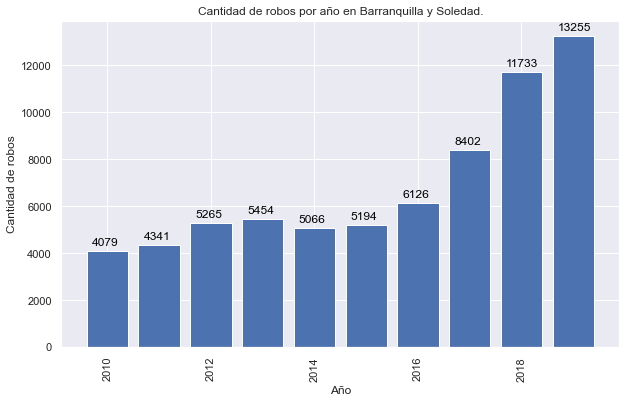

In [121]:
# Cantidad de hurtos por año sumando la columna cantidad
df_pivot_year = df.groupby(["Year"])["Cantidad"].sum().reset_index()
print(df_pivot_year.head(10))

plt.figure(figsize=(10, 6))
plt.bar(df_pivot_year["Year"], df_pivot_year["Cantidad"])
plt.xticks(rotation=90)
plt.xlabel("Año")
plt.ylabel("Cantidad de robos")
plt.title("Cantidad de robos por año en Barranquilla y Soledad.")
for i, v in df_pivot_year.values:
    plt.text(i - 0.3, v + 250, str(v), color="black")
plt.show()

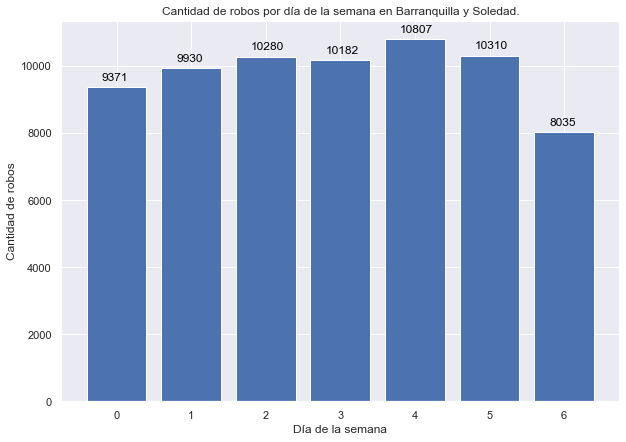

In [120]:
df_pivot_weekday = df.groupby(["WeekDay"])["Cantidad"].sum().reset_index()

plt.figure(figsize=(10, 7))
plt.bar(df_pivot_weekday["WeekDay"], df_pivot_weekday["Cantidad"])
# plt.xticks(rotation=90)
plt.xlabel("Día de la semana")
plt.ylabel("Cantidad de robos")
plt.title("Cantidad de robos por día de la semana en Barranquilla y Soledad.")
for i, v in df_pivot_weekday.values:
    plt.text(i - 0.2, v + 200, str(v), color="black")

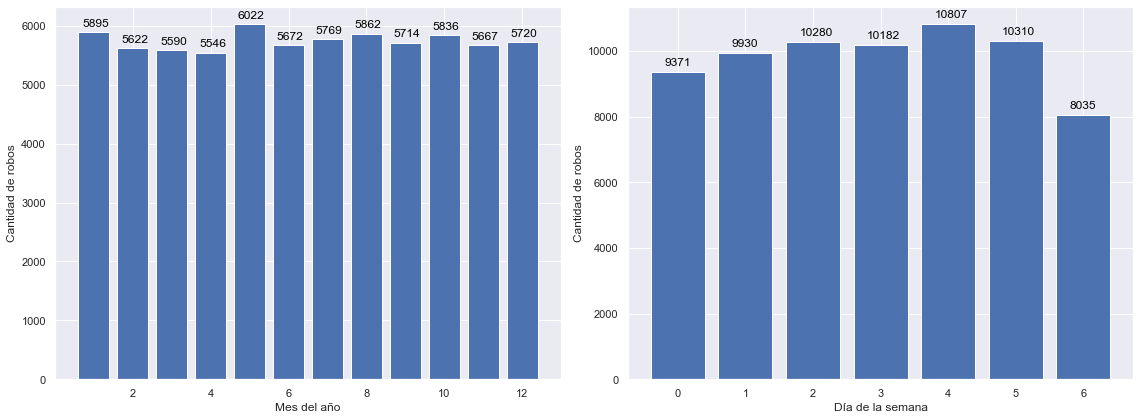

In [83]:
df_pivot_month = df.groupby(["Month"])["Cantidad"].sum().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.bar(df_pivot_month["Month"], df_pivot_month["Cantidad"])
ax1.set_xlabel("Mes del año")
ax1.set_ylabel("Cantidad de robos")
for i, v in df_pivot_month.values:
    ax1.text(i - 0.3, v + 100, str(v), color="black")

ax2.bar(df_pivot_weekday["WeekDay"], df_pivot_weekday["Cantidad"])
ax2.set_xlabel("Día de la semana")
ax2.set_ylabel("Cantidad de robos")
for i, v in df_pivot_weekday.values:
    ax2.text(i - 0.2, v + 200, str(v), color="black")
fig.tight_layout()

In [47]:
# Creating a pivot table for weekday for each year
df_pivot_year_weekday = df.groupby(["Year", "WeekDay"])["Cantidad"].sum().reset_index()
df_pivot_year_weekday.head(10)

,Year,WeekDay,Cantidad
0,2010,0,568
1,2010,1,567
2,2010,2,599
3,2010,3,644
4,2010,4,632
5,2010,5,663
6,2010,6,406
7,2011,0,596
8,2011,1,606
9,2011,2,717


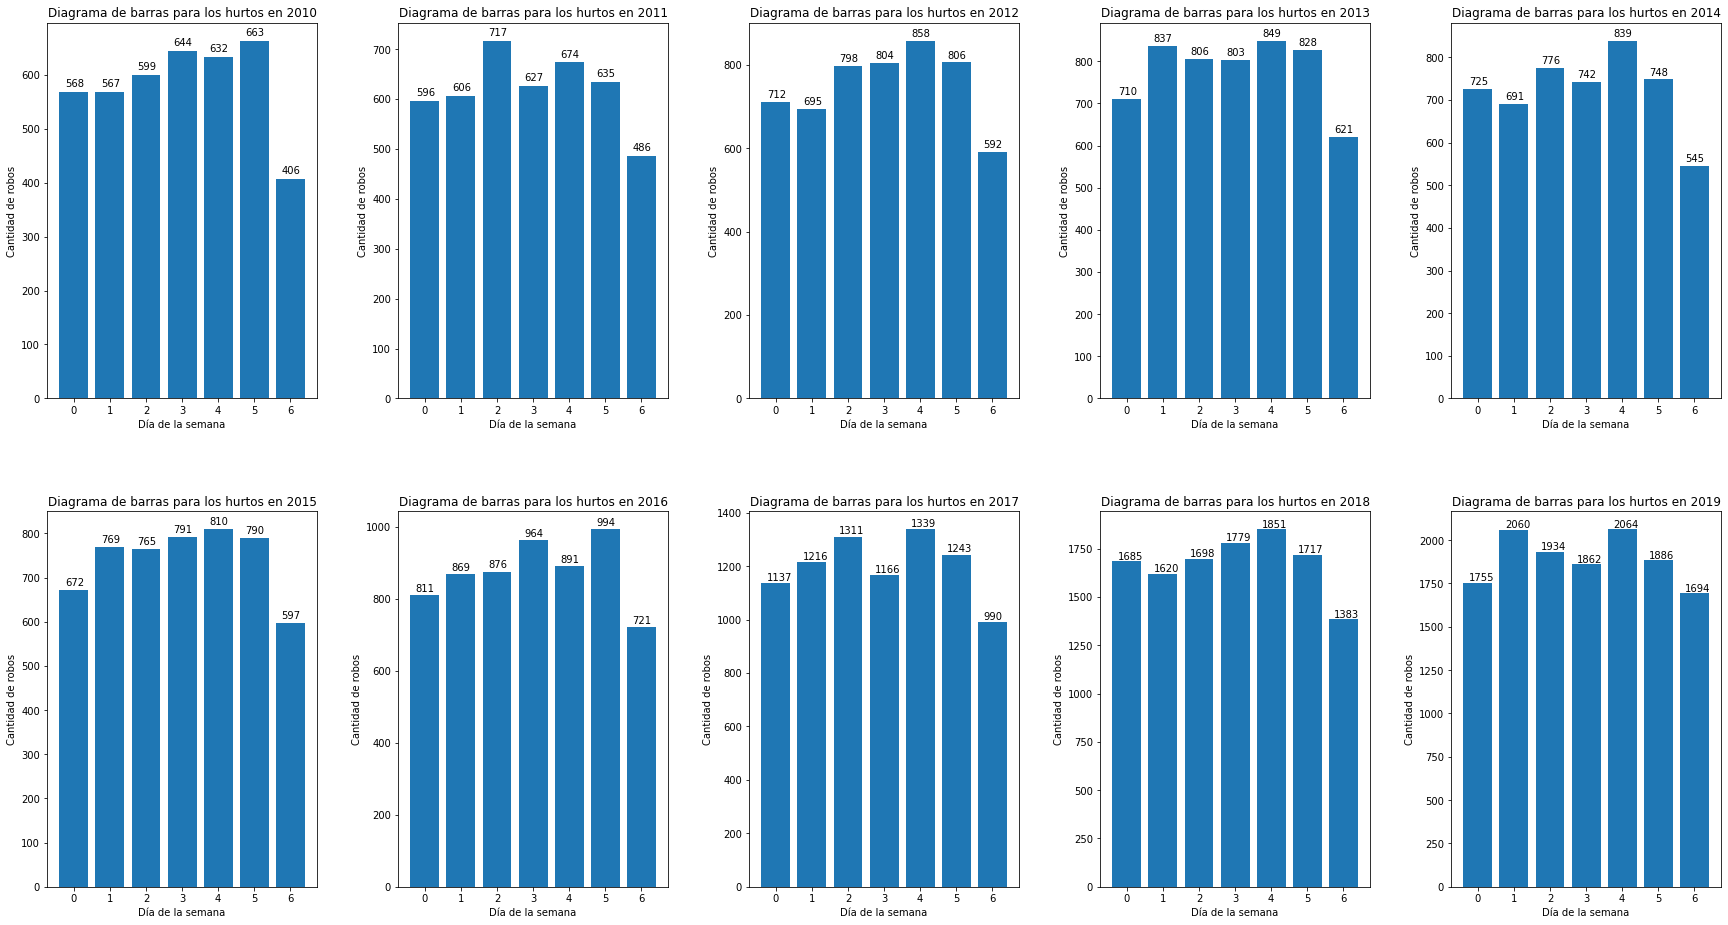

In [48]:
# Creating a plot per weekday per year
plt.figure(figsize=(30, 15))
vars_to_plot = list(df_pivot_year_weekday["Year"].unique())
for i, var in enumerate(vars_to_plot):
    plt.subplot(2, 5, i + 1)
    dummy = df_pivot_year_weekday[df_pivot_year_weekday["Year"] == var][
        ["WeekDay", "Cantidad"]
    ]
    plt.bar(dummy["WeekDay"], dummy["Cantidad"])
    plt.ylabel("Cantidad de robos")
    plt.xlabel("Día de la semana")
    plt.subplots_adjust(
        left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3
    )
    # plt.xticks(rotation=90)
    title_string = "Diagrama de barras para los hurtos en " + str(var)
    plt.title(title_string)
    for j, v in dummy.values:
        plt.text(j - 0.25, v + 10, str(v), color="black")

In [49]:
# Creating a month column (period)
df["Month_period"] = df["Date"].dt.to_period("M")

# Creating a pivot table for each month for each year
df_pivot_year_month = (
    df.groupby(["Month_period"])["Cantidad"]
    .sum()
    .reset_index()
    .sort_values(by="Month_period")
)
df_pivot_year_month.head(10)

,Month_period,Cantidad
0,2010-01,325
1,2010-02,274
2,2010-03,297
3,2010-04,335
4,2010-05,352
5,2010-06,342
6,2010-07,370
7,2010-08,348
8,2010-09,368
9,2010-10,371


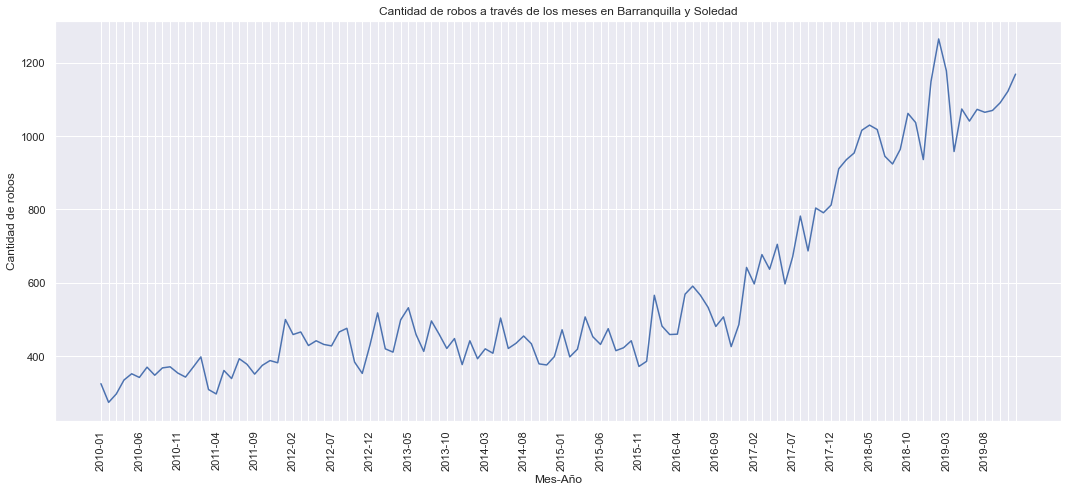

In [113]:
# Generating a line plot over months
plt.figure(figsize=(15, 7))
plt.plot(df_pivot_year_month["Cantidad"])
plt.title("Cantidad de robos a través de los meses en Barranquilla y Soledad")
plt.xlabel("Mes-Año")

xaxis_l = (
    df_pivot_year_month["Month_period"].apply(lambda x: str(x)).reset_index(drop=True)
)
xticks_l = range(df_pivot_year_month.shape[0])

plt.xticks(
    ticks=xticks_l,
    labels=[
        x if i in range(0, df_pivot_year_month.shape[0], 5) else ""
        for i, x in enumerate(xaxis_l)
    ],
    rotation=90,
)
plt.ylabel("Cantidad de robos")
plt.tight_layout()
plt.show()

In [51]:
# Checking armas usadas, change per month period
df_pivot_year_month_armas = (
    df.groupby(["Arma empleada", "Month_period"])["Cantidad"]
    .sum()
    .reset_index()
    .sort_values(by="Month_period")
)
df_pivot_year_month_armas["Month_period"] = df_pivot_year_month_armas[
    "Month_period"
].apply(lambda x: str(x))
df_pivot_year_month_armas.head(10)

,Arma empleada,Month_period,Cantidad
0,ARMA BLANCA / CORTOPUNZANTE,2010-01,38
360,ESCOPOLAMINA,2010-01,5
120,ARMA DE FUEGO,2010-01,158
474,NO REPORTADO,2010-01,37
568,SIN EMPLEO DE ARMAS,2010-01,72
240,CONTUNDENTES,2010-01,15
241,CONTUNDENTES,2010-02,20
1,ARMA BLANCA / CORTOPUNZANTE,2010-02,25
361,ESCOPOLAMINA,2010-02,2
475,NO REPORTADO,2010-02,34


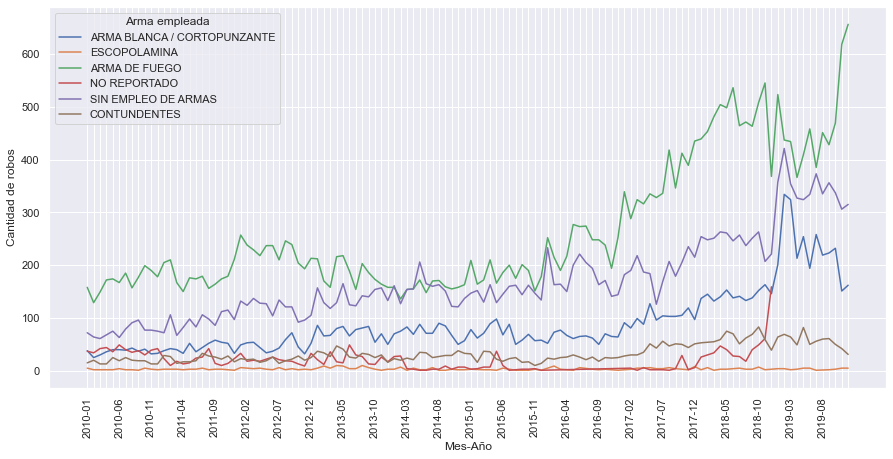

In [115]:
# Let"s plot the main weapons
plt.figure(figsize=(15, 7))
ax = sns.lineplot(
    x="Month_period", y="Cantidad", hue="Arma empleada", data=df_pivot_year_month_armas
)

plt.xticks(
    ticks=xticks_l,
    labels=[
        x if i in range(0, df_pivot_year_month.shape[0], 5) else ""
        for i, x in enumerate(xaxis_l)
    ],
    rotation=90,
)

plt.xlabel("Mes-Año")
plt.ylabel("Cantidad de robos")
plt.show()

In [53]:
# Checking top 5 movil agresor, change per month period
top_five = df["Móvil Agresor"].value_counts()[:5]
print(top_five.index)
print()
df_pivot_year_month_movil = (
    df[df["Móvil Agresor"].isin(top_five.index)]
    .groupby(["Móvil Agresor", "Month_period"])["Cantidad"]
    .sum()
    .reset_index()
    .sort_values(by="Month_period")
)
df_pivot_year_month_movil["Month_period"] = df_pivot_year_month_armas[
    "Month_period"
].apply(lambda x: str(x))
df_pivot_year_month_movil.head(10)

Index(['A PIE', 'CONDUCTOR MOTOCICLETA', 'PASAJERO MOTOCICLETA',
       'PASAJERO BUS', 'NO REPORTADO'],
      dtype='object')



,Móvil Agresor,Month_period,Cantidad
0,A PIE,2010-01,175
240,NO REPORTADO,2010-01,43
120,CONDUCTOR MOTOCICLETA,2010-01,92
1,A PIE,2010-02,134
241,NO REPORTADO,2010-02,50
121,CONDUCTOR MOTOCICLETA,2010-02,69
316,PASAJERO BUS,2016-05,3
242,NO REPORTADO,2010-03,27
2,A PIE,2010-03,168
317,PASAJERO BUS,2016-06,1


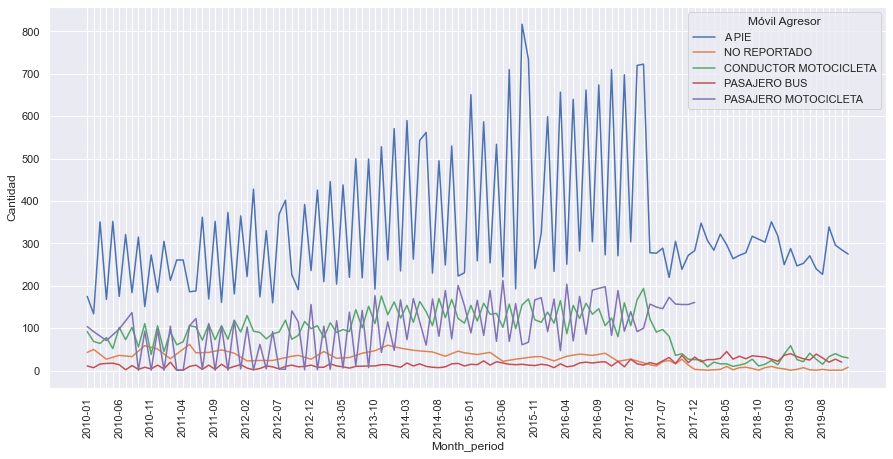

In [116]:
# Let"s plot the main vehicles for agressors
plt.figure(figsize=(15, 7))
ax = sns.lineplot(
    x="Month_period", y="Cantidad", hue="Móvil Agresor", data=df_pivot_year_month_movil
)
plt.xticks(
    ticks=xticks_l,
    labels=[
        x if i in range(0, df_pivot_year_month.shape[0], 5) else ""
        for i, x in enumerate(xaxis_l)
    ],
    rotation=90,
)
plt.show()

In [55]:
df.columns

Index(['Municipio', 'Arma empleada', 'Móvil Agresor', 'Móvil Victima', 'Edad',
       'Sexo', 'Estado civil', 'País de nacimiento', 'Clase de empleado',
       'Escolaridad', 'Cantidad', 'GEOID', 'Barrio', 'Categoria de sitio',
       'Date', 'Year', 'Month', 'Day', 'WeekDay', 'Hour', 'Month_period'],
      dtype='object')

In [56]:
# Checking hurtos per gender
df_pivot_year_month_gender = (
    df.groupby(["Sexo", "Month_period"])["Cantidad"]
    .sum()
    .reset_index()
    .sort_values(by="Month_period")
)
df_pivot_year_month_gender["Month_period"] = df_pivot_year_month_gender[
    "Month_period"
].apply(lambda x: str(x))
df_pivot_year_month_gender.head(10)

,Sexo,Month_period,Cantidad
0,FEMENINO,2010-01,113
240,NO REPORTA,2010-01,1
120,MASCULINO,2010-01,211
1,FEMENINO,2010-02,98
121,MASCULINO,2010-02,176
2,FEMENINO,2010-03,92
241,NO REPORTA,2010-03,1
122,MASCULINO,2010-03,204
3,FEMENINO,2010-04,115
123,MASCULINO,2010-04,220


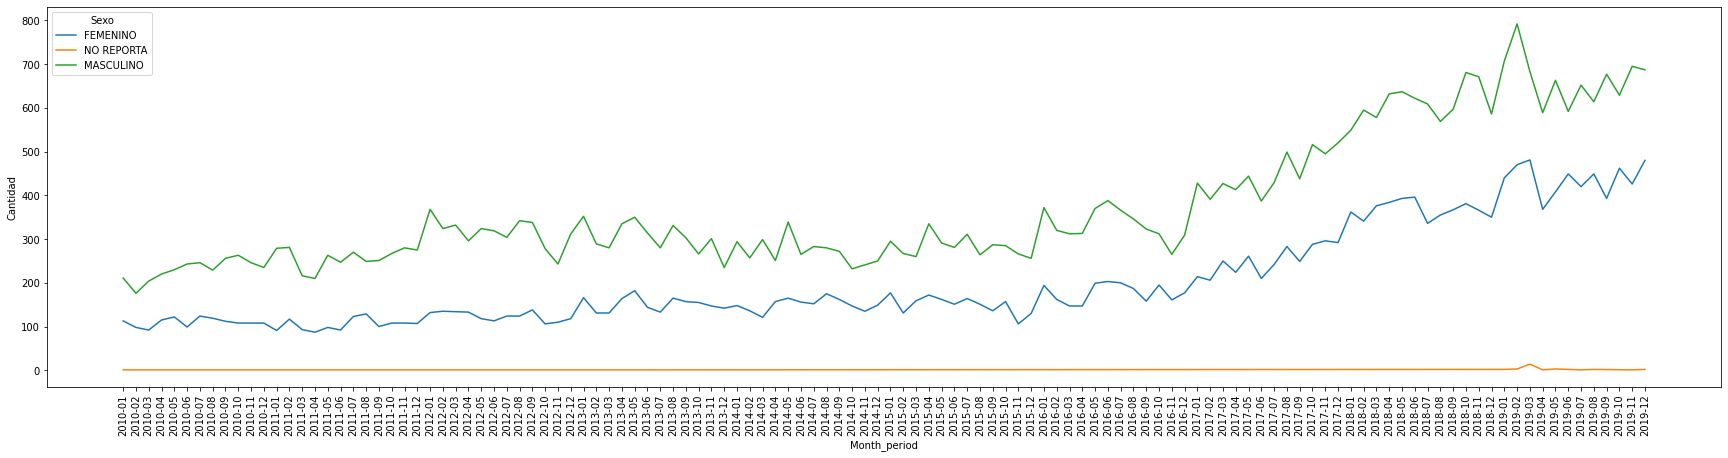

In [57]:
# Let"s plot the main vehicles for agressors
plt.figure(figsize=(30, 7))
ax = sns.lineplot(
    x="Month_period", y="Cantidad", hue="Sexo", data=df_pivot_year_month_gender
)
plt.xticks(rotation=90)
plt.show()

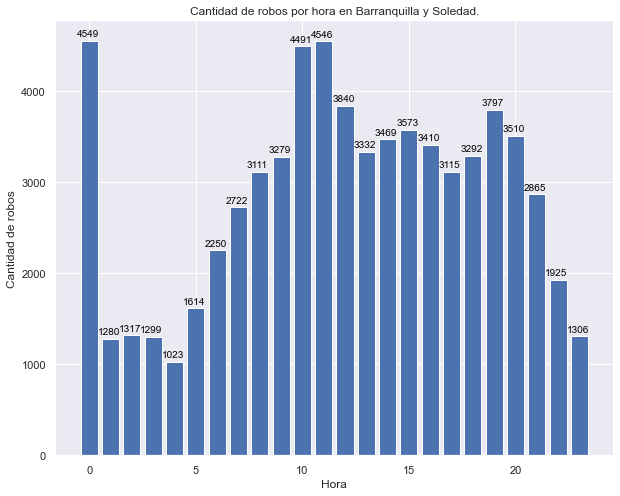

In [122]:
# barplot por hora
df_pivot_hour = df.groupby(["Hour"])["Cantidad"].sum().reset_index()

plt.figure(figsize=(10, 8))
plt.bar(df_pivot_hour["Hour"], df_pivot_hour["Cantidad"])
# plt.xticks(rotation=90)
plt.xlabel("Hora")
plt.ylabel("Cantidad de robos")
plt.title("Cantidad de robos por hora en Barranquilla y Soledad.")
for i, v in df_pivot_hour.values:
    plt.text(i - 0.6, v + 50, str(v), color="black", fontsize="small")

In [59]:
# lineplot por barrio
top_neigh = df["Barrio"].value_counts()[:7]
print(top_neigh.index)
print()

df_pivot_year_month_neigh = (
    df[df["Barrio"].isin(top_neigh.index)]
    .groupby(["Barrio", "Month_period"])["Cantidad"]
    .sum()
    .reset_index()
    .sort_values(by="Month_period")
)
df_pivot_year_month_neigh["Month_period"] = df_pivot_year_month_neigh[
    "Month_period"
].apply(lambda x: str(x))
df_pivot_year_month_neigh.head(10)

Index(['CENTRO', 'EL PRADO', 'CIUDADELA 20 DE JULIO', 'REBOLO', 'BOSTON',
       'LAS TORRES', 'ALTO PRADO'],
      dtype='object')



,Barrio,Month_period,Cantidad
0,ALTO PRADO,2010-01,5
120,BOSTON,2010-01,10
360,CIUDADELA 20 DE JULIO,2010-01,6
480,EL PRADO,2010-01,16
655,REBOLO,2010-01,7
240,CENTRO,2010-01,18
241,CENTRO,2010-02,22
361,CIUDADELA 20 DE JULIO,2010-02,7
1,ALTO PRADO,2010-02,8
656,REBOLO,2010-02,7


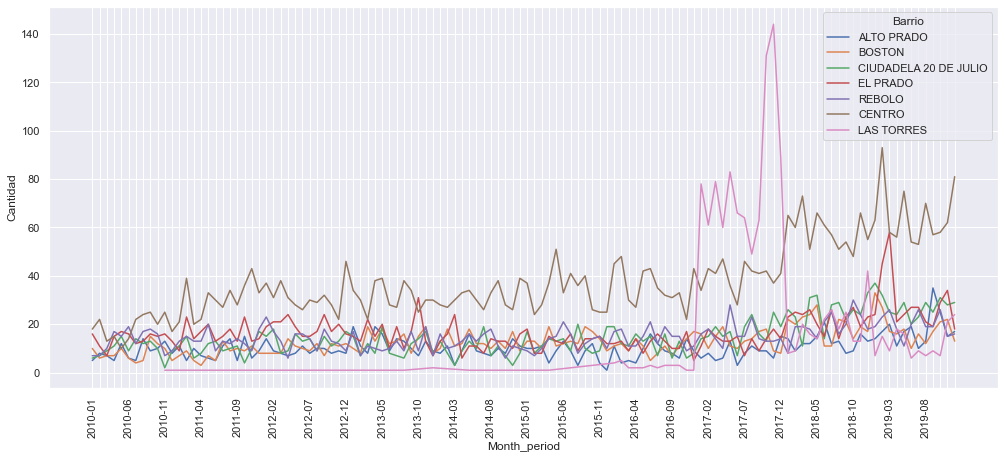

In [119]:
# Let"s plot the main neighborhoods per month-year
plt.figure(figsize=(17, 7))
ax = sns.lineplot(
    x="Month_period", y="Cantidad", hue="Barrio", data=df_pivot_year_month_neigh
)
plt.xticks(
    ticks=xticks_l,
    labels=[
        x if i in range(0, df_pivot_year_month.shape[0], 5) else ""
        for i, x in enumerate(xaxis_l)
    ],
    rotation=90,
)
plt.show()

In [61]:
# Checking hurtos per escolaridad
df_pivot_year_month_escolaridad = (
    df.groupby(["Escolaridad", "Month_period"])["Cantidad"]
    .sum()
    .reset_index()
    .sort_values(by="Month_period")
)
df_pivot_year_month_escolaridad["Month_period"] = df_pivot_year_month_escolaridad[
    "Month_period"
].apply(lambda x: str(x))
df_pivot_year_month_escolaridad.head(10)

,Escolaridad,Month_period,Cantidad
149,PRIMARIA,2010-01,14
269,SECUNDARIA,2010-01,163
389,SUPERIOR,2010-01,115
509,TECNICO,2010-01,23
42,NO REPORTADO,2010-01,7
629,TECNOLOGO,2010-01,3
270,SECUNDARIA,2010-02,136
390,SUPERIOR,2010-02,90
510,TECNICO,2010-02,18
150,PRIMARIA,2010-02,16


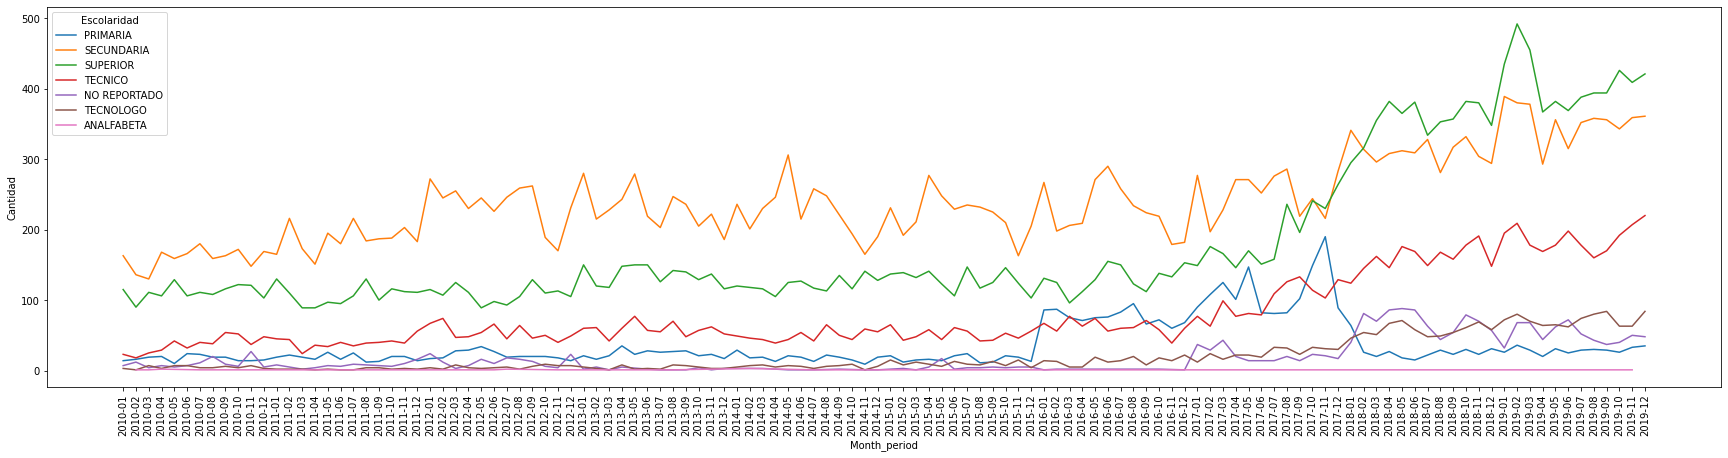

In [62]:
# lineplot por escolaridad
plt.figure(figsize=(30, 7))
ax = sns.lineplot(
    x="Month_period",
    y="Cantidad",
    hue="Escolaridad",
    data=df_pivot_year_month_escolaridad,
)
plt.xticks(rotation=90)
plt.show()

In [63]:
# checking hurtos por clase de empleado
top_empleado = df["Clase de empleado"].value_counts()[:7]
print(top_empleado.index)
print()

df_pivot_year_month_empleado = (
    df[df["Clase de empleado"].isin(top_empleado.index)]
    .groupby(["Clase de empleado", "Month_period"])["Cantidad"]
    .sum()
    .reset_index()
    .sort_values(by="Month_period")
)
df_pivot_year_month_empleado["Month_period"] = df_pivot_year_month_empleado[
    "Month_period"
].apply(lambda x: str(x))
df_pivot_year_month_empleado.head(10)

Index(['EMPLEADO PARTICULAR', 'INDEPENDIENTE', 'ESTUDIANTE', 'AMA DE CASA',
       'COMERCIANTE', 'NO REPORTA', 'DESEMPLEADO'],
      dtype='object')



,Clase de empleado,Month_period,Cantidad
0,AMA DE CASA,2010-01,19
480,ESTUDIANTE,2010-01,12
600,INDEPENDIENTE,2010-01,74
120,COMERCIANTE,2010-01,18
720,NO REPORTA,2010-01,27
240,DESEMPLEADO,2010-01,7
360,EMPLEADO PARTICULAR,2010-01,148
601,INDEPENDIENTE,2010-02,62
1,AMA DE CASA,2010-02,10
481,ESTUDIANTE,2010-02,17


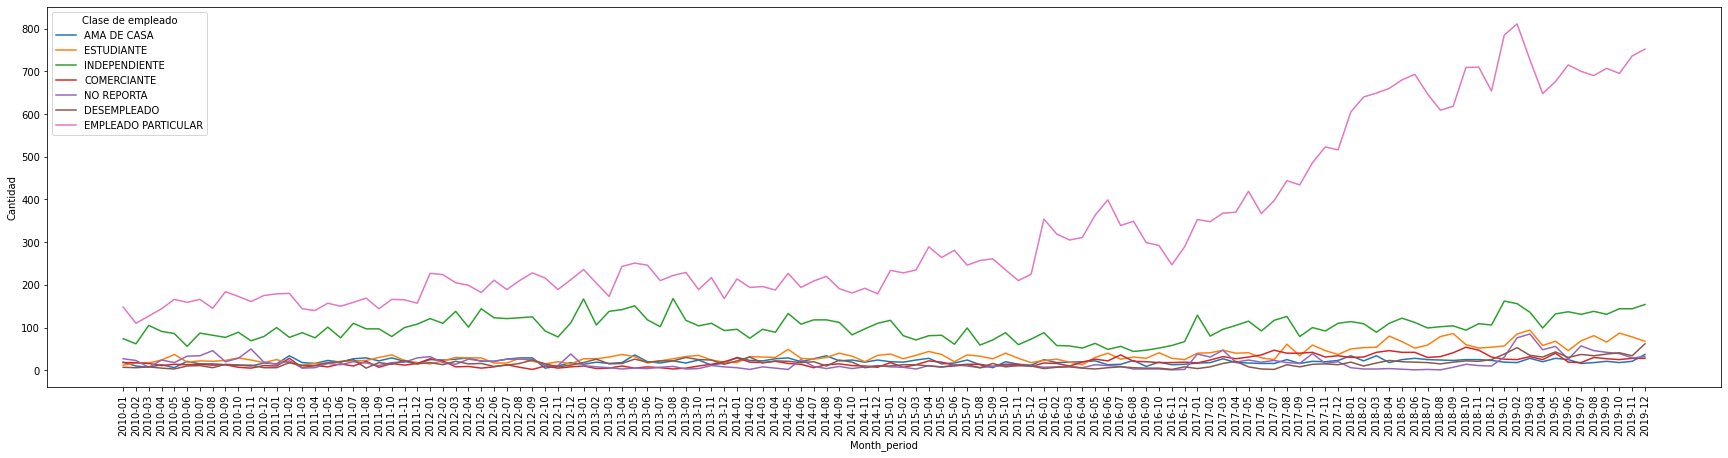

In [64]:
# lineplot por clase de empleado
plt.figure(figsize=(30, 7))
ax = sns.lineplot(
    x="Month_period",
    y="Cantidad",
    hue="Clase de empleado",
    data=df_pivot_year_month_empleado,
)
plt.xticks(rotation=90)
plt.show()

In [65]:
# Tabla por categoría de sitio
top_cat_sitio = df["Categoria de sitio"].value_counts()[:7]
print(top_cat_sitio.index)
print()

df_pivot_year_month_cat = (
    df[df["Categoria de sitio"].isin(top_cat_sitio.index)]
    .groupby(["Categoria de sitio", "Month_period"])["Cantidad"]
    .sum()
    .reset_index()
    .sort_values(by="Month_period")
)
df_pivot_year_month_cat["Month_period"] = df_pivot_year_month_cat["Month_period"].apply(
    lambda x: str(x)
)
df_pivot_year_month_cat.head(10)

Index(['VIAS PUBLICAS Y LOTES', 'LOCALES COMERCIALES', 'VIVIENDAS',
       'SERVICIO Y ENTIDADES PUBLICAS', 'OTRO'],
      dtype='object')



,Categoria de sitio,Month_period,Cantidad
0,LOCALES COMERCIALES,2010-01,39
323,VIAS PUBLICAS Y LOTES,2010-01,262
210,SERVICIO Y ENTIDADES PUBLICAS,2010-01,2
443,VIVIENDAS,2010-01,21
120,OTRO,2010-01,1
211,SERVICIO Y ENTIDADES PUBLICAS,2010-02,2
324,VIAS PUBLICAS Y LOTES,2010-02,218
444,VIVIENDAS,2010-02,15
1,LOCALES COMERCIALES,2010-02,28
121,OTRO,2010-02,11


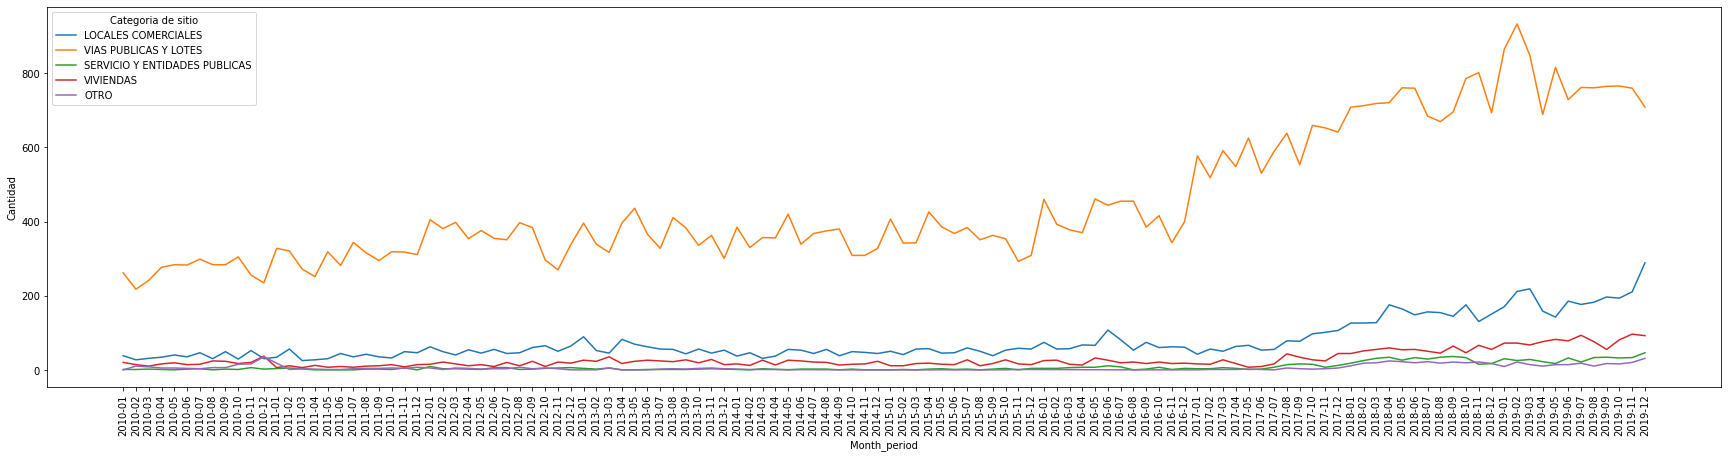

In [66]:
plt.figure(figsize=(30, 7))
ax = sns.lineplot(
    x="Month_period",
    y="Cantidad",
    hue="Categoria de sitio",
    data=df_pivot_year_month_cat,
)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


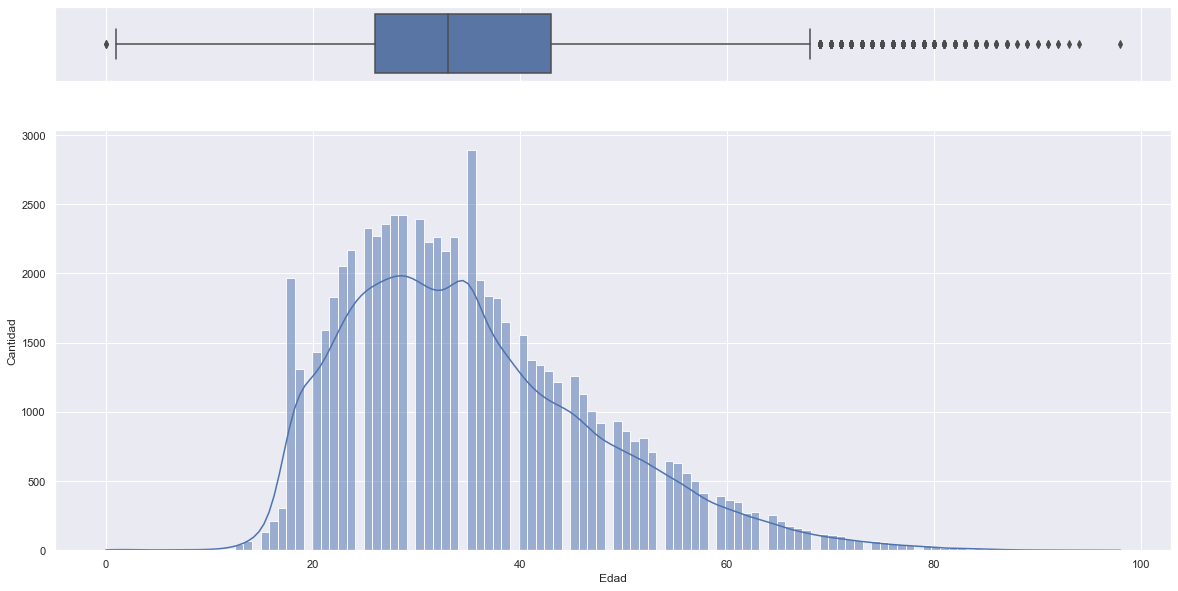

In [124]:
# histogram for age
f, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}, figsize=(20, 10)
)

sns.set(style="darkgrid")
sns.boxplot(df["Edad"], ax=ax_box)
sns.histplot(df["Edad"], ax=ax_hist, kde=True)
# Remove x axis name for the boxplot
ax_box.set(xlabel="")
ax_box.set(yticks=[])

ax_hist.set(xlabel="Edad")
ax_hist.set(ylabel="Cantidad")
# ax_box.set(title="Distribución de la edad en los robos")
plt.show()

In [125]:
df["Edad"].describe()

count    67911.000000
mean        35.407121
std         12.276732
min          0.000000
25%         26.000000
50%         33.000000
75%         43.000000
max         98.000000
Name: Edad, dtype: float64

In [139]:
df["Edad"].quantile([0.05, 0.95])

0.05    19.0
0.95    59.0
Name: Edad, dtype: float64

## Feature engineering

En este apartado, vamos a agregar variables como si el día es día de la madre, carnavales, quincena. Y luego, agregaremos los datos por día, fecha y hora, para saber cuántos robos ocurren agrupando estos valores.

In [140]:
df.columns

Index(['Municipio', 'Arma empleada', 'Móvil Agresor', 'Móvil Victima', 'Edad',
       'Sexo', 'Estado civil', 'País de nacimiento', 'Clase de empleado',
       'Escolaridad', 'Cantidad', 'GEOID', 'Barrio', 'Categoria de sitio',
       'Date', 'Year', 'Month', 'Day', 'WeekDay', 'Hour', 'Month_period'],
      dtype='object')

In [141]:
df.head()

,Municipio,Arma empleada,Móvil Agresor,Móvil Victima,Edad,Sexo,Estado civil,País de nacimiento,Clase de empleado,Escolaridad,...,GEOID,Barrio,Categoria de sitio,Date,Year,Month,Day,WeekDay,Hour,Month_period
0,BARRANQUILLA (CT),SIN EMPLEO DE ARMAS,A PIE,A PIE,39.0,FEMENINO,SOLTERO,NACIONAL,EMPLEADO PARTICULAR,PRIMARIA,...,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES,2019-01-07,2019,1,7,0,19,2019-01
1,BARRANQUILLA (CT),ARMA DE FUEGO,CONDUCTOR MOTOCICLETA,PASAJERO MOTOCICLETA,32.0,MASCULINO,UNION LIBRE,NACIONAL,EMPLEADO PARTICULAR,SECUNDARIA,...,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES,2019-01-07,2019,1,7,0,9,2019-01
2,BARRANQUILLA (CT),ARMA DE FUEGO,A PIE,A PIE,40.0,FEMENINO,CASADO,NACIONAL,EMPLEADO PARTICULAR,SECUNDARIA,...,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES,2019-10-07,2019,10,7,0,20,2019-10
3,BARRANQUILLA (CT),SIN EMPLEO DE ARMAS,A PIE,A PIE,39.0,MASCULINO,UNION LIBRE,NACIONAL,EMPLEADO PARTICULAR,SECUNDARIA,...,137,CORDIALIDAD,SERVICIO Y ENTIDADES PUBLICAS,2019-07-13,2019,7,13,5,18,2019-07
4,BARRANQUILLA (CT),SIN EMPLEO DE ARMAS,A PIE,A PIE,33.0,MASCULINO,SOLTERO,NACIONAL,EMPLEADO PARTICULAR,SECUNDARIA,...,137,CORDIALIDAD,VIAS PUBLICAS Y LOTES,2019-07-21,2019,7,21,6,0,2019-07


En este caso, primero construiremos las variables que necesitamos para el modelo, antes de agregar los datos. Las variables que se escogieron para el modelo son: 
- ¿Es o no es quincena?
- ¿Es día de la madre?
- ¿Es día de carnaval?

Y siguiendo los pre-procesamientos mencionados en Chapter 16 - Crime Modeling (insertar citación), agregaremos las horas en tres bandas (mañana, tarde y noche), y usaremos los meses y días de la semana para agregar la información también.

In [142]:
df_model = df.drop(
    columns=[
        "Móvil Agresor",
        "Móvil Victima",
        "Edad",
        "Estado civil",
        "País de nacimiento",
        "Sexo",
        "Clase de empleado",
        "Escolaridad",
        "Month_period",
        "Day",
    ]
)
df_model.columns

Index(['Municipio', 'Arma empleada', 'Cantidad', 'GEOID', 'Barrio',
       'Categoria de sitio', 'Date', 'Year', 'Month', 'WeekDay', 'Hour'],
      dtype='object')

In [143]:
# Día de las madres
mothers_day = [
    dt.date(2010, 5, 9),
    dt.date(2011, 5, 8),
    dt.date(2012, 5, 13),
    dt.date(2013, 5, 12),
    dt.date(2014, 5, 11),
    dt.date(2015, 5, 10),
    dt.date(2016, 5, 8),
    dt.date(2017, 5, 14),
    dt.date(2018, 5, 13),
    dt.date(2019, 5, 12),
]

# Carnavales
carnavales = [
    dt.date(2010, 2, 13),
    dt.date(2010, 2, 14),
    dt.date(2010, 2, 15),
    dt.date(2010, 2, 16),
    dt.date(2011, 3, 5),
    dt.date(2011, 3, 6),
    dt.date(2011, 3, 7),
    dt.date(2011, 3, 8),
    dt.date(2012, 2, 18),
    dt.date(2012, 2, 19),
    dt.date(2012, 2, 20),
    dt.date(2012, 2, 21),
    dt.date(2013, 2, 9),
    dt.date(2013, 2, 10),
    dt.date(2013, 2, 11),
    dt.date(2013, 2, 12),
    dt.date(2014, 3, 1),
    dt.date(2014, 3, 2),
    dt.date(2014, 3, 3),
    dt.date(2014, 3, 4),
    dt.date(2015, 2, 14),
    dt.date(2015, 2, 15),
    dt.date(2015, 2, 16),
    dt.date(2015, 2, 17),
    dt.date(2016, 2, 6),
    dt.date(2016, 2, 7),
    dt.date(2016, 2, 8),
    dt.date(2016, 2, 9),
    dt.date(2017, 2, 25),
    dt.date(2017, 2, 26),
    dt.date(2017, 2, 27),
    dt.date(2017, 2, 28),
    dt.date(2018, 2, 10),
    dt.date(2018, 2, 11),
    dt.date(2018, 2, 12),
    dt.date(2018, 2, 13),
    dt.date(2019, 3, 2),
    dt.date(2019, 3, 3),
    dt.date(2019, 3, 4),
    dt.date(2019, 3, 5),
]

In [144]:
# Featuring columns
df_model["Quincena"] = [
    1 if x in [14, 15, 16, 28, 29, 30, 31] else 0 for x in df_model["Date"].dt.day
]
df_model["Dia_Madre"] = [1 if x in mothers_day else 0 for x in df_model["Date"].dt.date]
df_model["Carnaval"] = [1 if x in carnavales else 0 for x in df_model["Date"].dt.date]
df_model["Timeframe"] = [
    "Noche" if x in range(18, 24) else "Dia" if x in range(7, 18) else "Madrugada"
    for x in df_model["Hour"]
]

In [191]:
4 * 12 + 2 * 11 + 7

77

In [146]:
df_model.to_csv("df_model_dias_esp.csv", index=False)

In [165]:
df_pivot_carnaval = (
    df_model.groupby(["Year", "Carnaval"])["Cantidad"].sum().reset_index()
)
# Creando dataframe para carnaval
df_carnaval = df_pivot_carnaval[df_pivot_carnaval["Carnaval"] == 1][
    ["Year", "Cantidad"]
]
df_carnaval["Cantidad"] = df_carnaval["Cantidad"] / 4

# Creando dataframe para no carnaval
df_carnaval_no = df_pivot_carnaval[df_pivot_carnaval["Carnaval"] == 0][
    ["Year", "Cantidad"]
]
df_carnaval_no["Cantidad"] = df_carnaval_no["Cantidad"] / 361

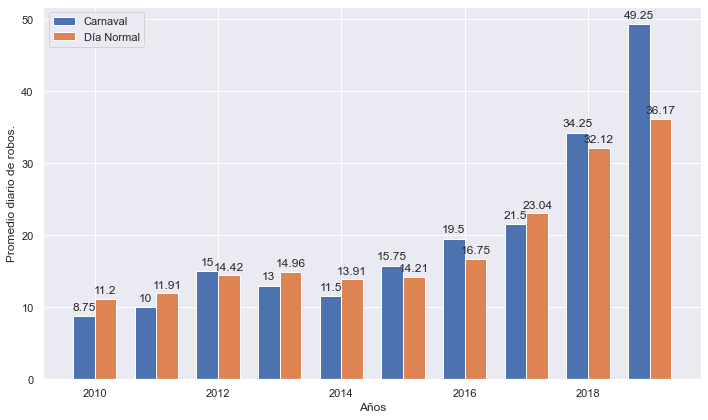

In [179]:
labels = df_carnaval["Year"].values
# x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(
    labels - width / 2, df_carnaval["Cantidad"].round(2).values, width, label="Carnaval"
)
rects2 = ax.bar(
    labels + width / 2,
    df_carnaval_no["Cantidad"].round(2).values,
    width,
    label="Día Normal",
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Promedio diario de robos.")
ax.set_xlabel("Años")
# ax.set_title('Scores by group and gender')

ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [180]:
# barplot por dia de la madre
df_pivot_madre = df_model.groupby(["Year", "Dia_Madre"])["Cantidad"].sum().reset_index()

# Creando dataframe para Dia_Madre
df_madre = df_pivot_madre[df_pivot_madre["Dia_Madre"] == 1][["Year", "Cantidad"]]
df_madre["Cantidad"] = df_madre["Cantidad"]

# Creando dataframe para no Dia_Madre
df_madre_no = df_pivot_madre[df_pivot_madre["Dia_Madre"] == 0][["Year", "Cantidad"]]
df_madre_no["Cantidad"] = df_madre_no["Cantidad"] / 364

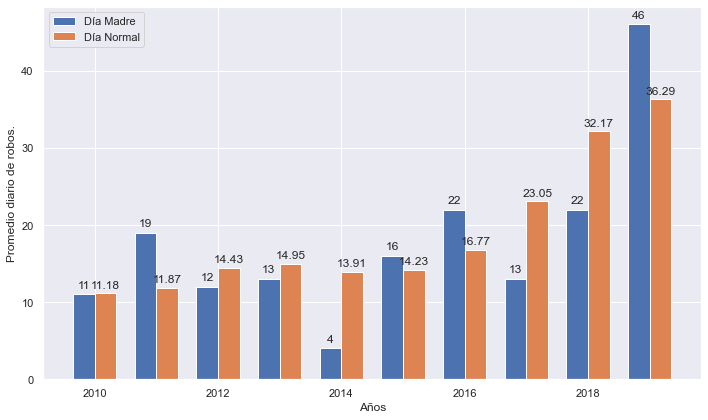

In [185]:
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(
    labels - width / 2, df_madre["Cantidad"].values, width, label="Día Madre"
)
rects2 = ax.bar(
    labels + width / 2,
    df_madre_no["Cantidad"].round(2).values,
    width,
    label="Día Normal",
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Promedio diario de robos.")
ax.set_xlabel("Años")

ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [193]:
# barplot por dia de la madre
df_pivot_quincena = (
    df_model.groupby(["Year", "Quincena"])["Cantidad"].sum().reset_index()
)

# Creando dataframe para quincena
df_quincena = df_pivot_quincena[df_pivot_quincena["Quincena"] == 1][
    ["Year", "Cantidad"]
]
df_quincena["Cantidad"] = df_quincena["Cantidad"] / 77

# Creando dataframe para no quincena
df_quincena_no = df_pivot_quincena[df_pivot_quincena["Quincena"] == 0][
    ["Year", "Cantidad"]
]
df_quincena_no["Cantidad"] = df_quincena_no["Cantidad"] / 288

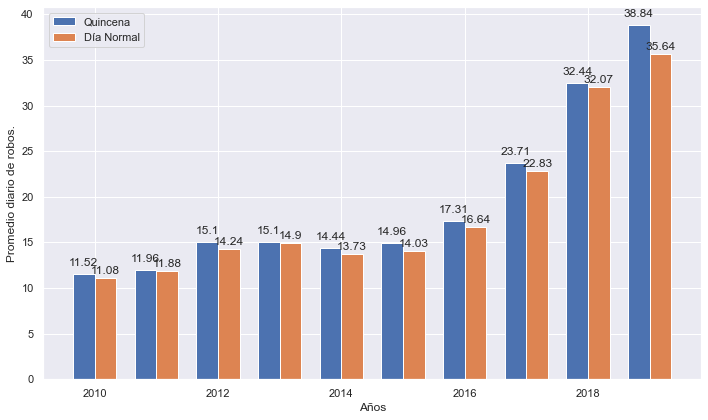

In [197]:
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(
    labels - width / 2, df_quincena["Cantidad"].round(2).values, width, label="Quincena"
)
rects2 = ax.bar(
    labels + width / 2,
    df_quincena_no["Cantidad"].round(2).values,
    width,
    label="Día Normal",
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Promedio diario de robos.")
ax.set_xlabel("Años")

ax.legend()

ax.bar_label(rects1, padding=6)
ax.bar_label(rects2, padding=2)

fig.tight_layout()

plt.show()

In [198]:
# Agrupando las variables
df_grouped = (
    df_model.groupby(
        [
            "Municipio",
            # "Localidad",
            "Barrio",
            # "GEOID",
            # "Categoria de sitio",
            # "Arma empleada",
            "Year",
            # "Month",
            "WeekDay",
            "Timeframe",
            # "Quincena",
            # "Dia_Madre",
            # "Carnaval",
        ]
    )["Cantidad"]
    .sum()
    .reset_index()
)
df_grouped["Cantidad"] = df_grouped["Cantidad"]
df_grouped

,Municipio,Barrio,Year,WeekDay,Timeframe,Cantidad
0,BARRANQUILLA (CT),20 DE JULIO,2010,0,Dia,1
1,BARRANQUILLA (CT),20 DE JULIO,2010,0,Noche,4
2,BARRANQUILLA (CT),20 DE JULIO,2010,3,Dia,1
3,BARRANQUILLA (CT),20 DE JULIO,2010,3,Noche,2
4,BARRANQUILLA (CT),20 DE JULIO,2010,4,Dia,2
...,...,...,...,...,...,...
23723,SOLEDAD,VISTA HERMOSA,2019,5,Madrugada,15
23724,SOLEDAD,VISTA HERMOSA,2019,5,Noche,4
23725,SOLEDAD,VISTA HERMOSA,2019,6,Dia,18
23726,SOLEDAD,VISTA HERMOSA,2019,6,Madrugada,12


In [402]:
df_grouped["Cantidad"].describe()

count    30907.000000
mean         2.229754
std          2.820876
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        130.000000
Name: Cantidad, dtype: float64

In [257]:
df_grouped[df_grouped["Cantidad"] >= 3]

,Municipio,Barrio,WeekDay,Timeframe,Cantidad


Text(0, 0.5, 'Cantidad')

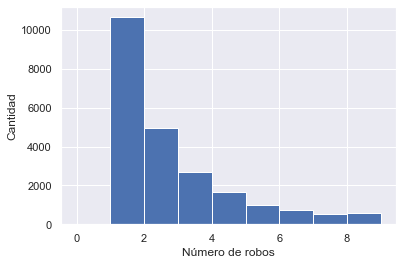

In [200]:
df_grouped["Cantidad"].hist(bins=range(0, 10))
plt.xlabel("Número de robos")
plt.ylabel("Cantidad")

In [201]:
df_grouped.dtypes

Municipio    object
Barrio       object
Year          int64
WeekDay       int64
Timeframe    object
Cantidad      int64
dtype: object

## Model training

Con las variables agrupadas y listas, dividamos nuestro dataset en train y test, y empecemos a entrenar los modelos. Para este caso, primero realizaremos el OneHotEncoding de las variables, y la estandarización antes de realizar el train/test split.

In [202]:
df_grouped.columns

Index(['Municipio', 'Barrio', 'Year', 'WeekDay', 'Timeframe', 'Cantidad'], dtype='object')

In [203]:
# Escogiendo X y Y
X = df_grouped.drop(columns=["Municipio", "Year", "Cantidad"])
y = df_grouped["Cantidad"]

###Realizando OneHotEnconding para todas las columnas
hotEncoder = OneHotEncoder(sparse=False, drop="if_binary")
aux_cat = hotEncoder.fit_transform(X)
columnas_dummies_cat = hotEncoder.get_feature_names(X.columns)

X_cat = pd.DataFrame(aux_cat, columns=columnas_dummies_cat)
# X_cat = pd.concat([X_cat, X[["Quincena", "Dia_Madre", "Carnaval"]]], axis=1)
X_cat

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Barrio_12 DE OCTUBRE,Barrio_20 DE JULIO,Barrio_7 DE ABRIL,Barrio_7 DE AGOSTO,Barrio_ALFONSO LOPEZ,Barrio_ALTAMIRA,Barrio_ALTO DE LOS ROBLES,Barrio_ALTO PRADO,Barrio_ALTOS DE RIOMAR,Barrio_ALTOS DEL LIMON,...,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,Timeframe_Dia,Timeframe_Madrugada,Timeframe_Noche
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
23724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
23725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
23726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [205]:
# Dividiendo train, test split
random_state = np.random.RandomState(30)
X_train, X_test, y_train, y_test = train_test_split(
    X_cat.values, y.values, test_size=0.2, random_state=random_state
)

In [206]:
model_poisson = PoissonRegressor()

param_poisson = {"alpha": [0.01, 0.1, 0.5, 1, 3, 10]}
# GridSearch
clf_poisson = GridSearchCV(
    model_poisson, param_poisson, scoring="neg_mean_squared_error", n_jobs=-1
)
# model_poisson.fit(X_train, y_train)

# Entrenando el modelo
clf_poisson.fit(X_train, y_train)

GridSearchCV(estimator=PoissonRegressor(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1, 3, 10]},
             scoring='neg_mean_squared_error')

In [207]:
clf_poisson.cv_results_["mean_test_score"]

array([-11.04661624, -13.93000409, -15.55136054, -15.85747691,
       -16.16128596, -16.33967664])

In [208]:
print(clf_poisson.best_score_)
clf_poisson.best_params_

-11.046616240117398


{'alpha': 0.01}

In [209]:
# Entrenando el mejor modelo para mirar sus métricas
model_poisson = PoissonRegressor(alpha=0.01)
model_poisson.fit(X_train, y_train)

PoissonRegressor(alpha=0.01)

In [210]:
# Métricas en el train set
print(
    f"\n MAE: {mean_absolute_error(model_poisson.predict(X_train), y_train)} \n RMSE: {mean_squared_error(model_poisson.predict(X_train), y_train)**0.5} \n "
)


 MAE: 1.6011766555638531 
 RMSE: 3.2983453311199566 
 


In [211]:
# Métricas en el test set
print(
    f"\n MAE: {mean_absolute_error(model_poisson.predict(X_test), y_test)} \n RMSE: {mean_squared_error(model_poisson.predict(X_test), y_test)**0.5}"
)


 MAE: 1.6381914815512022 
 RMSE: 3.7458236062820918


In [212]:
r2_score(y_train, model_poisson.predict(X_train))

0.33839471691107403

In [213]:
r2_score(y_test, model_poisson.predict(X_test))

0.3198774925594138

Se observa que se tienen buenos resultados tanto en el train set como en el test set, tanto para el MAE (aproximadamente 0.12 puntos), como para el RMSE (0.33). Si bien, el modelo ofrece una buena métrica de predicción, debemos verificar los supuestos. Cómo este es un modelo de poisson, la esperanza de la variable respuesta debe ser igual a su varianza.

In [214]:
e_poisson = np.mean(y)
e_poisson

2.904374578556979

In [215]:
v_poisson = np.std(y) ** 2
v_poisson

17.281019298665957

Cómo se puede observar, la varianza es mucho más grande que la esperanza de la variable respuesta. Esto nos indica que tenemos un problema de sobre-dispersión. En el R-markdown, se probaron diversos modelos que permiten sortear este inconveniente.

### Entrenando otros tipos de modelo

El modelo de Poisson está dando resultados muy buenos, pero queremos revisar si hay otros tipos de modelos que pueden hacerlo mejor. Por la naturaleza de las variables independientes, podríamos utilizar un regresor de árbol (ya que estos modelos ofrecene buenos resultados cuando tenemos variables dicotómicas). Probemos entonces un randomForest normal:

In [216]:
# RandomForest por default
rf = RandomForestRegressor(random_state=random_state, n_jobs=-1)

# Entrenando el modelo
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1,
                      random_state=RandomState(MT19937) at 0x12D0C1E40)

In [217]:
# Métricas en el train set
print(
    f"\n MAE: {mean_absolute_error(rf.predict(X_train), y_train)} \n RMSE: {mean_squared_error(rf.predict(X_train), y_train)**0.5} \n "
)


 MAE: 1.2808271747403814 
 RMSE: 2.9069884975643143 
 


In [218]:
# Métricas en el test set
print(
    f"\n MAE: {mean_absolute_error(rf.predict(X_test), y_test)} \n RMSE: {mean_squared_error(rf.predict(X_test), y_test)**0.5}"
)


 MAE: 1.5570119222820036 
 RMSE: 3.6959906190131004


In [370]:
r2_score(y_train, rf.predict(X_train))

0.6736856860763674

In [371]:
r2_score(y_test, rf.predict(X_test))

0.39551838854973875

## Explicabilidad de los resultados con LIME
LIME es el acrónimo de Local Interpretable Model-agnostic Explanations. Este paquete de Machine Learning nos permite explicar la importancia de los features para una predicción específica. Con esto, podremos saber que factores están afectando más la predicción y por que el modelo está arrojando los resultados que arroja. Para usar lime, importaremos el módulo `lime`.

In [ ]:
# Entrenando el modelo LIME que nos permite explicar la importancia de los features
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    X_train, mode="regression", feature_names=X_cat.columns
)
explainer

In [ ]:
# Seleccionando un valor aleatorio de test
idx = random.randint(1, len(X_test))

print("Prediction : ", model_poisson.predict(X_test[idx].reshape(1, -1)))
print("Actual :     ", y_test[idx])

explanation = explainer.explain_instance(
    X_test[idx], model_poisson.predict, num_features=len(X_cat.columns)
)
explanation

Prediction :  [1.049087]
Actual :      1


In [ ]:
X_cat.iloc[idx, :][X_cat.iloc[idx, :] == 1]

Barrio_BETANIA                               1.0
Categoria de sitio_VIAS PUBLICAS             1.0
Arma empleada_ARMA BLANCA / CORTOPUNZANTE    1.0
Month_6                                      1.0
WeekDay_6                                    1.0
Timeframe_Noche                              1.0
Name: 4844, dtype: float64

In [ ]:
explanation.show_in_notebook()

In [ ]:
with plt.style.context("ggplot"):
    explanation.as_pyplot_figure()

In [ ]:
from IPython.display import HTML

html_data = explanation.as_html()
HTML(data=html_data)

## Exportando el modelo, y configurando las predicciones para el dashboard

In [407]:
# Reentrenando el modelo con toda la información
model_poisson = PoissonRegressor(alpha=0.01)
model_poisson.fit(X_cat.values, y.values)

PoissonRegressor(alpha=0.01)

In [385]:
import pickle

pickle.dump(model_poisson, open("poisson_model.pickle", "wb"))

In [386]:
model_poisson = pickle.load(open("poisson_model.pickle", "rb"))

In [420]:
PREDICT_COLUMNS = {
    # "Categoria de sitio_AEROPUERTO": 0,
    # "Categoria de sitio_AREA RURAL": 0,
    # "Categoria de sitio_CENTRO EDUCATIVO": 0,
    # "Categoria de sitio_CENTRO RELIGIOSO": 0,
    # "Categoria de sitio_CENTRO SOCIAL/CULTURAL": 0,
    # "Categoria de sitio_CENTRO TURISTICO/RECREACIONAL": 0,
    # "Categoria de sitio_CONSTRUCCION": 0,
    # "Categoria de sitio_ENTIDAD PUBLICA": 0,
    # "Categoria de sitio_ESTACION TRANSPORTE PUBLICO": 0,
    # "Categoria de sitio_FUERZA PUBLICA": 0,
    # "Categoria de sitio_INSTITUTOS DE SALUD": 0,
    # "Categoria de sitio_LOCAL ALIMENTOS": 0,
    # "Categoria de sitio_LOCAL COMERCIAL": 0,
    # "Categoria de sitio_LOCAL FINANCIERO": 0,
    # "Categoria de sitio_LOCAL SERVICIO AUTOMOTRIZ": 0,
    # "Categoria de sitio_LOCAL SERVICIO ENTRETENIMIENTO": 0,
    # "Categoria de sitio_LOCAL SERVICIO HOSPEDAJE": 0,
    # "Categoria de sitio_LOTE BALDIO": 0,
    # "Categoria de sitio_OTRO": 0,
    # "Categoria de sitio_SECTOR INDUSTRIA": 0,
    # "Categoria de sitio_SECTOR MARITIMO Y FLUVIAL": 0,
    # "Categoria de sitio_SERVICIO FUNERARIO": 0,
    # "Categoria de sitio_VIAS PUBLICAS": 0,
    # "Categoria de sitio_VIVIENDAS": 0,
    # "Arma empleada_ARMA BLANCA / CORTOPUNZANTE": 0,
    # "Arma empleada_ARMA DE FUEGO": 0,
    # "Arma empleada_CONTUNDENTES": 0,
    # "Arma empleada_ESCOPOLAMINA": 0,
    # "Arma empleada_NO REPORTADO": 0,
    # "Arma empleada_SIN EMPLEO DE ARMAS": 0,
    "Month_1": 0,
    "Month_2": 0,
    "Month_3": 0,
    "Month_4": 0,
    "Month_5": 0,
    "Month_6": 0,
    "Month_7": 0,
    "Month_8": 0,
    "Month_9": 0,
    "Month_10": 0,
    "Month_11": 0,
    "Month_12": 0,
    # "WeekDay_0": 0,
    # "WeekDay_1": 0,
    # "WeekDay_2": 0,
    # "WeekDay_3": 0,
    # "WeekDay_4": 0,
    # "WeekDay_5": 0,
    # "WeekDay_6": 0,
    "Timeframe_Dia": 0,
    "Timeframe_Madrugada": 0,
    "Timeframe_Noche": 0,
    # "Quincena": 0,
    # "Dia_Madre": 0,
    # "Carnaval": 0,
}

In [388]:
BARRIOS = [
    "Barrio_12 DE OCTUBRE",
    "Barrio_20 DE JULIO",
    "Barrio_7 DE ABRIL",
    "Barrio_7 DE AGOSTO",
    "Barrio_ALFONSO LOPEZ",
    "Barrio_ALTAMIRA",
    "Barrio_ALTO DE LOS ROBLES",
    "Barrio_ALTO PRADO",
    "Barrio_ALTOS DE RIOMAR",
    "Barrio_ALTOS DEL LIMON",
    "Barrio_AMERICA",
    "Barrio_ANDALUCIA",
    "Barrio_ATLANTICO",
    "Barrio_BARLOVENTO",
    "Barrio_BARRIO ABAJO",
    "Barrio_BELLA ARENA",
    "Barrio_BELLA MURILLO",
    "Barrio_BELLAVISTA",
    "Barrio_BETANIA",
    "Barrio_BONANZA",
    "Barrio_BOSTON",
    "Barrio_BOYACA",
    "Barrio_BUENA ESPERANZA",
    "Barrio_BUENAVISTA",
    "Barrio_BUENOS AIRES",
    "Barrio_CABRERA",
    "Barrio_CACHIMBERO",
    "Barrio_CALIFORNIA",
    "Barrio_CAMPO ALEGRE",
    "Barrio_CARLOS MEISEL",
    "Barrio_CARRIZAL",
    "Barrio_CENTENARIO",
    "Barrio_CENTRO",
    "Barrio_CEVILLAR",
    "Barrio_CHIQUINQUIRA",
    "Barrio_CIUDAD BOLIVAR",
    "Barrio_CIUDAD BONITA",
    "Barrio_CIUDAD CAMELOT",
    "Barrio_CIUDAD JARDIN",
    "Barrio_CIUDAD MODESTO",
    "Barrio_CIUDAD PARAISO",
    "Barrio_CIUDADELA 20 DE JULIO",
    "Barrio_CIUDADELA METROPOLITANA",
    "Barrio_COLOMBIA",
    "Barrio_CONJUNTO LOS MANGOS",
    "Barrio_CONTINENTES",
    "Barrio_CORDIALIDAD",
    "Barrio_COSTA HERMOSA",
    "Barrio_CUCHILLA DE VILLATE",
    "Barrio_DELICIAS",
    "Barrio_DOÑA MANUELA",
    "Barrio_DOÑA SOLEDAD",
    "Barrio_EL BOSQUE",
    "Barrio_EL CAMPITO",
    "Barrio_EL CARMEN",
    "Barrio_EL CASTILLO",
    "Barrio_EL EDEN 2000",
    "Barrio_EL ENCANTO",
    "Barrio_EL ESFUERZO",
    "Barrio_EL FERROCARRIL",
    "Barrio_EL FERRY",
    "Barrio_EL GOLF",
    "Barrio_EL GOLFO",
    "Barrio_EL HIPODROMO",
    "Barrio_EL LIMONCITO",
    "Barrio_EL MANANTIAL",
    "Barrio_EL MILAGRO",
    "Barrio_EL OASIS",
    "Barrio_EL PARQUE",
    "Barrio_EL POBLADO",
    "Barrio_EL PORVENIR",
    "Barrio_EL PRADO",
    "Barrio_EL PUEBLO",
    "Barrio_EL RECREO",
    "Barrio_EL ROMANCE",
    "Barrio_EL ROSARIO",
    "Barrio_EL SILENCIO",
    "Barrio_EL TABOR",
    "Barrio_EL TRIUNFO",
    "Barrio_EL TUCAN",
    "Barrio_EL VALLE",
    "Barrio_EVARISTO SOURDIS",
    "Barrio_GRANADILLO",
    "Barrio_JERUSALEM",
    "Barrio_JOSE ANTONIO GALAN",
    "Barrio_JUAN DOMINGUEZ ROMERO",
    "Barrio_JUAN MINA",
    "Barrio_KALAMARY",
    "Barrio_KENNEDY",
    "Barrio_LA ALBORAYA",
    "Barrio_LA ALIANZA",
    "Barrio_LA ARBOLEDA",
    "Barrio_LA CAMPIÑA",
    "Barrio_LA CANDELARIA I",
    "Barrio_LA CANDELARIA II",
    "Barrio_LA CEIBA",
    "Barrio_LA CENTRAL",
    "Barrio_LA CHINITA",
    "Barrio_LA CONCEPCION",
    "Barrio_LA CRUZ DE MAYO",
    "Barrio_LA CUMBRE",
    "Barrio_LA ESMERALDA",
    "Barrio_LA ESPERANZA",
    "Barrio_LA FARRUCA",
    "Barrio_LA FE",
    "Barrio_LA FLORESTA",
    "Barrio_LA FLORIDA",
    "Barrio_LA GLORIA",
    "Barrio_LA ILUSION",
    "Barrio_LA INMACULADA",
    "Barrio_LA LIBERTAD",
    "Barrio_LA LOMA",
    "Barrio_LA LUZ",
    "Barrio_LA MAGDALENA",
    "Barrio_LA MANGA",
    "Barrio_LA MARIA",
    "Barrio_LA PAZ",
    "Barrio_LA PLAYA",
    "Barrio_LA PRADERA",
    "Barrio_LA SIERRA",
    "Barrio_LA SIERRITA",
    "Barrio_LA UNION",
    "Barrio_LA VICTORIA",
    "Barrio_LA VIOLA I",
    "Barrio_LA VIOLA II",
    "Barrio_LAS AMERICAS",
    "Barrio_LAS COLINAS",
    "Barrio_LAS COLONIAS",
    "Barrio_LAS COMETAS",
    "Barrio_LAS DUNAS",
    "Barrio_LAS ESTRELLAS",
    "Barrio_LAS FERIAS",
    "Barrio_LAS FLORES",
    "Barrio_LAS GARDENIAS",
    "Barrio_LAS GAVIOTAS",
    "Barrio_LAS GRANJAS",
    "Barrio_LAS MALVINAS",
    "Barrio_LAS MARGARITAS",
    "Barrio_LAS MERCEDES",
    "Barrio_LAS MORAS",
    "Barrio_LAS NIEVES",
    "Barrio_LAS NUBES",
    "Barrio_LAS PALMAS",
    "Barrio_LAS TERRAZAS",
    "Barrio_LAS TORRES",
    "Barrio_LAS TRES AVE MARIAS",
    "Barrio_LAS TRINITARIAS",
    "Barrio_LIMON",
    "Barrio_LIPAYA",
    "Barrio_LOMA FRESCA",
    "Barrio_LOS ALMENDROS",
    "Barrio_LOS ALMENDROS III",
    "Barrio_LOS ALPES",
    "Barrio_LOS ANDES",
    "Barrio_LOS ANGELES I",
    "Barrio_LOS ARRAYANES",
    "Barrio_LOS BALCANES",
    "Barrio_LOS CEDROS",
    "Barrio_LOS CUSULES",
    "Barrio_LOS FUNDADORES",
    "Barrio_LOS GIRASOLES",
    "Barrio_LOS JOBOS",
    "Barrio_LOS LAURELES",
    "Barrio_LOS LOTEROS",
    "Barrio_LOS NOGALES",
    "Barrio_LOS OLIVOS I",
    "Barrio_LOS OLIVOS II",
    "Barrio_LOS PINOS",
    "Barrio_LOS ROBLES",
    "Barrio_LOS ROSALES",
    "Barrio_LOS TRUPILLOS",
    "Barrio_LUCERO",
    "Barrio_MANUELA BELTRAN",
    "Barrio_ME QUEJO",
    "Barrio_MERCEDES SUR",
    "Barrio_MIRAMAR",
    "Barrio_MODELO",
    "Barrio_MONTECRISTO",
    "Barrio_MONTES",
    "Barrio_NORMANDIA",
    "Barrio_NUEVA COLOMBIA",
    "Barrio_NUEVA ESPERANZA I",
    "Barrio_NUEVA GRANADA",
    "Barrio_NUEVO HORIZONTE",
    "Barrio_NUEVO MILENIO",
    "Barrio_OLAYA HERRERA",
    "Barrio_ORIENTAL",
    "Barrio_PARAISO",
    "Barrio_PASADENA",
    "Barrio_PINAR DEL RIO",
    "Barrio_POR FIN",
    "Barrio_PORTAL DE LOS NOGALES",
    "Barrio_PRADO SOLEDAD",
    "Barrio_PRIMERO DE MAYO",
    "Barrio_PUERTA DE ORO",
    "Barrio_PUMAREJO",
    "Barrio_REBOLO",
    "Barrio_RENACER",
    "Barrio_RESERVA DE LOS ALMENDROS",
    "Barrio_RIOMAR",
    "Barrio_SAL SI PUEDES",
    "Barrio_SALAMANCA",
    "Barrio_SALCEDO",
    "Barrio_SAN ANTONIO",
    "Barrio_SAN BERNARDO",
    "Barrio_SAN FELIPE",
    "Barrio_SAN FRANCISCO",
    "Barrio_SAN ISIDRO",
    "Barrio_SAN JOSE",
    "Barrio_SAN LUIS",
    "Barrio_SAN NICOLAS",
    "Barrio_SAN PEDRO ALEJANDRINO",
    "Barrio_SAN ROQUE",
    "Barrio_SAN SALVADOR",
    "Barrio_SAN VICENTE",
    "Barrio_SANTA ANA",
    "Barrio_SANTA HELENA",
    "Barrio_SANTA INES",
    "Barrio_SANTA MARIA",
    "Barrio_SANTA MONICA",
    "Barrio_SANTO DOMINGO",
    "Barrio_SANTO DOMINGO DE GUZMAN",
    "Barrio_SANTUARIO",
    "Barrio_SIAPE",
    "Barrio_SIMON BOLIVAR",
    "Barrio_SOLEDAD 2000",
    "Barrio_TAYRONA",
    "Barrio_TERRANOVA II",
    "Barrio_UNIVERSAL",
    "Barrio_VILLA ADELA",
    "Barrio_VILLA BLANCA",
    "Barrio_VILLA CAMPESTRE",
    "Barrio_VILLA CAROLINA",
    "Barrio_VILLA CECILIA",
    "Barrio_VILLA COUNTRY",
    "Barrio_VILLA DEL CARMEN",
    "Barrio_VILLA DEL ESTE",
    "Barrio_VILLA DEL REY",
    "Barrio_VILLA DEL ROSARIO",
    "Barrio_VILLA ESTADIO I",
    "Barrio_VILLA ESTADIO II",
    "Barrio_VILLA ESTADIO III",
    "Barrio_VILLA ESTEFANNY",
    "Barrio_VILLA FLOR",
    "Barrio_VILLA KARLA",
    "Barrio_VILLA KATANGA",
    "Barrio_VILLA LAS MORAS I",
    "Barrio_VILLA LAS MORAS II",
    "Barrio_VILLA LINDA",
    "Barrio_VILLA LOZANO",
    "Barrio_VILLA MARIA",
    "Barrio_VILLA MERLY",
    "Barrio_VILLA MONACO",
    "Barrio_VILLA MONIK",
    "Barrio_VILLA MUVDI",
    "Barrio_VILLA ROSA",
    "Barrio_VILLA SAN CARLOS",
    "Barrio_VILLA SAN PEDRO II",
    "Barrio_VILLA SANTOS",
    "Barrio_VILLA SELENE",
    "Barrio_VILLA SEVERA",
    "Barrio_VILLA SEVILLA",
    "Barrio_VILLA SOL",
    "Barrio_VILLA SOLEDAD",
    "Barrio_VILLA VALENTINA",
    "Barrio_VILLA ZAMBRANO",
    "Barrio_VILLANUEVA",
    "Barrio_VILLAS DE SAN PABLO",
    "Barrio_VILLAS DEL PORTAL",
    "Barrio_VILLATE",
    "Barrio_VISTA HERMOSA",
    "Barrio_ZONA FRANCA",
]

In [421]:
df_pred = pd.DataFrame(np.diag([1] * len(BARRIOS)), columns=BARRIOS)
df_pred.shape

(272, 272)

In [422]:
X_cat.shape

(30907, 287)

In [423]:
X_cat.drop_duplicates(subset=BARRIOS).shape

(272, 287)

In [447]:
# Variables seleccionables en el dashboard
# cat_model = "Categoria de sitio_SECTOR INDUSTRIA"
# arma_model = "Arma empleada_ARMA DE FUEGO"
mes_model = "Month_12"
# day_model = "WeekDay_6"
time_model = "Timeframe_Madrugada"
# special_days = ["Quincena"]

# Creating a new dictionary with these values
v = 1
upd_dict = {k: v for k in [mes_model, time_model]}

# for x in special_days:
#    upd_dict[x] = 1

upd_dict

{'Month_12': 1, 'Timeframe_Madrugada': 1}

In [448]:
pr_col = PREDICT_COLUMNS.copy()
# pr_col

In [449]:
pr_col.update(upd_dict)

In [450]:
pr_col.values()

dict_values([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [451]:
# After updating the dictionary, let"s give those values to the dataframe
df_pred[list(pr_col.keys())] = list(pr_col.values())

In [452]:
df_pred.shape

(272, 287)

In [453]:
# Constructing dataframe to map neighborhood to predicted value
df_predict_values = pd.DataFrame(columns=["Barrio", "Cantidad"])
df_predict_values

,Barrio,Cantidad


In [454]:
# Filling it
df_predict_values["Barrio"] = [x.split("_")[-1] for x in BARRIOS]
df_predict_values["Cantidad"] = model_poisson.predict(df_pred)
df_predict_values

/usr/local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but PoissonRegressor was fitted without feature names



,Barrio,Cantidad
0,12 DE OCTUBRE,1.470024
1,20 DE JULIO,1.376136
2,7 DE ABRIL,1.915034
3,7 DE AGOSTO,1.306950
4,ALFONSO LOPEZ,1.355910
...,...,...
267,VILLAS DE SAN PABLO,1.390880
268,VILLAS DEL PORTAL,1.478235
269,VILLATE,1.285893
270,VISTA HERMOSA,2.978136


<AxesSubplot:>

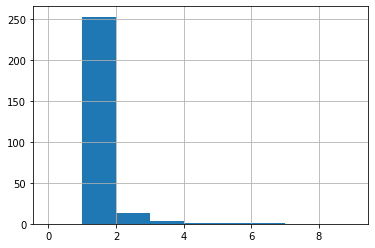

In [455]:
df_predict_values["Cantidad"].hist(bins=range(0, 10))

In [444]:
import geopandas

barrios_geopandas = geopandas.read_file(
    "./dashboard-thefts-local/assets/barrios.geojson", driver="GeoJSON"
)
barrios_geopandas["geometry"] = barrios_geopandas["geometry"].to_crs("EPSG:4326")

In [456]:
# Haciendo el merge con barrios_geopandas
bar_geo2 = barrios_geopandas[["Barrio", "GEOID"]].merge(
    df_predict_values, on="Barrio", how="left"
)
bar_geo2["Cantidad"] = bar_geo2["Cantidad"].fillna(0)

In [457]:
import plotly.express as px

mapa = px.choropleth_mapbox(
    bar_geo2,
    locations="GEOID",
    color="Cantidad",
    geojson=barrios_geopandas,
    hover_name="Barrio",
    # featureidkey="Cantidad",
    zoom=11,
    mapbox_style="carto-positron",
    center={"lat": 10.97, "lon": -74.8},
    color_continuous_scale="YlOrBr",
    range_color=(0, 12),
    opacity=0.5,
    labels={"Cantidad": "Cantidad de robos predicha:"},
)
mapa.update_layout(
    title="", paper_bgcolor="#F8F9F9", margin={"r": 0, "t": 0, "l": 0, "b": 0}
)